In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_eddies


Eddy    Day Cyc         Lon        Lat   ic   jc          xc  \
0          1   1462  CE  156.969773 -28.461100  179  274  505.897600   
1          1   1463  CE  156.993096 -28.433992  179  275  507.149717   
2          1   1464  CE  157.097940 -28.381485  181  276  515.130000   
3          1   1465  CE  157.094334 -28.315658  181  278  512.570772   
4          1   1466  CE  157.106324 -28.346479  181  277  514.728351   
...      ...    ...  ..         ...        ...  ...  ...         ...   
105233  2631  10646  AE  157.825620 -37.030656  248   97  850.502045   
105234  2631  10647  AE  157.880796 -36.972725  249   98  853.608024   
105235  2631  10648  AE  157.868516 -36.874363  248  100  849.759258   
105236  2631  10649  AE  157.753058 -36.882303  246   99  840.037603   
105237  2631  10650  AE  157.863435 -36.962331  248   98  851.818768   

                 yc         w       q11       q12       q22          Rc  \
0       1353.012251 -0.000033  1.099922 -0.193920  0.943344  104.677927   
1       1356.633687 -0.000030  1.066764 -0.119714  0.950849  110.542281   
2       1365.650728 -0.000028  1.016800 -0.154298  1.006892  115.245476   
3       1372.426342 -0.000033  0.896874 -0.276325  1.200119  114.738549   
4       1369.599726 -0.000029  0.847358 -0.169788  1.214160  100.425496   
...             ...       ...       ...       ...       ...         ...   
105233   476.447416  0.000013  0.898473  0.197470  1.156400  114.894173   
105234   484.316677  0.000014  0.884289  0.308226  1.238286  111.853372   
105235   494.400614  0.000014  0.883521  0.168561  1.163994  107.180060   
105236   489.981707  0.000013  0.873263  0.225002  1.203104  100.368133   
105237   484.885460  0.000014  0.910085  0.220492  1.152218  121.438271   

             psi0         A          R  Age       Date  \
0       71.391686 -0.006515  69.250036   57 1994-01-02   
1       77.351002 -0.006330  62.000626   57 1994-01-03   
2       75.250400 -0.005666  67.000485   57 1994-01-04   
3       72.789618 -0.005529  66.501582   57 1994-01-05   
4       58.705551 -0.005821  56.251116   57 1994-01-06   
...           ...       ...        ...  ...        ...   
105233 -41.491437  0.003143  72.751791   24 2019-02-24   
105234 -42.195517  0.003373  73.000933   24 2019-02-25   
105235 -43.102690  0.003752  75.750780   24 2019-02-26   
105236 -37.967048  0.003769  75.750006   24 2019-02-27   
105237 -47.159914  0.003198  68.750184   24 2019-02-28   

                                                    fname  
0       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
1       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
2       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
3       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
4       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
...                                                   ...  
105233  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
105234  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
105235  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
105236  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
105237  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  

[105238 rows x 20 columns]

In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
df_eddies


Eddy    Day Cyc         Lon        Lat   ic   jc          xc  \
0          1   1462  CE  156.969773 -28.461100  179  274  505.897600   
1          1   1463  CE  156.993096 -28.433992  179  275  507.149717   
2          1   1464  CE  157.097940 -28.381485  181  276  515.130000   
3          1   1465  CE  157.094334 -28.315658  181  278  512.570772   
4          1   1466  CE  157.106324 -28.346479  181  277  514.728351   
...      ...    ...  ..         ...        ...  ...  ...         ...   
105233  2631  10646  AE  157.825620 -37.030656  248   97  850.502045   
105234  2631  10647  AE  157.880796 -36.972725  249   98  853.608024   
105235  2631  10648  AE  157.868516 -36.874363  248  100  849.759258   
105236  2631  10649  AE  157.753058 -36.882303  246   99  840.037603   
105237  2631  10650  AE  157.863435 -36.962331  248   98  851.818768   

                 yc         w       q11       q12       q22          Rc  \
0       1353.012251 -0.000033  1.099922 -0.193920  0.943344  104.677927   
1       1356.633687 -0.000030  1.066764 -0.119714  0.950849  110.542281   
2       1365.650728 -0.000028  1.016800 -0.154298  1.006892  115.245476   
3       1372.426342 -0.000033  0.896874 -0.276325  1.200119  114.738549   
4       1369.599726 -0.000029  0.847358 -0.169788  1.214160  100.425496   
...             ...       ...       ...       ...       ...         ...   
105233   476.447416  0.000013  0.898473  0.197470  1.156400  114.894173   
105234   484.316677  0.000014  0.884289  0.308226  1.238286  111.853372   
105235   494.400614  0.000014  0.883521  0.168561  1.163994  107.180060   
105236   489.981707  0.000013  0.873263  0.225002  1.203104  100.368133   
105237   484.885460  0.000014  0.910085  0.220492  1.152218  121.438271   

             psi0         A          R  Age       Date  \
0       71.391686 -0.006515  69.250036   57 1994-01-02   
1       77.351002 -0.006330  62.000626   57 1994-01-03   
2       75.250400 -0.005666  67.000485   57 1994-01-04   
3       72.789618 -0.005529  66.501582   57 1994-01-05   
4       58.705551 -0.005821  56.251116   57 1994-01-06   
...           ...       ...        ...  ...        ...   
105233 -41.491437  0.003143  72.751791   24 2019-02-24   
105234 -42.195517  0.003373  73.000933   24 2019-02-25   
105235 -43.102690  0.003752  75.750780   24 2019-02-26   
105236 -37.967048  0.003769  75.750006   24 2019-02-27   
105237 -47.159914  0.003198  68.750184   24 2019-02-28   

                                                    fname  
0       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
1       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
2       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
3       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
4       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
...                                                   ...  
105233  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
105234  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
105235  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
105236  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
105237  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  

[105238 rows x 20 columns]

Calculate there vertical centers

In [4]:
with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)


In [5]:
# for e, eddy in enumerate(dic_eddies_vert.keys()):
#     dic = dic_eddies_vert[eddy]
#     df = compute_tilt_data(dic, int(eddy[4:]))
#     if e == 0:
#         df_tilt_data = df
#     else:
#         df_tilt_data = pd.concat([df_tilt_data, df], ignore_index=True)
# df_tilt_data.to_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl") 

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_tilt_data


Eddy    Day    TiltDis     TiltDir
0         1   1465  31.669332   89.546110
1         1   1466  33.600109   92.955602
2         1   1467  35.159201   96.662951
3         1   1468  35.643445  101.070039
4         1   1469  34.916207  105.866105
...     ...    ...        ...         ...
89447  2631  10643  10.685422  350.104683
89448  2631  10644  10.055826  348.769338
89449  2631  10645  11.563679  343.688930
89450  2631  10646  12.848125  334.097803
89451  2631  10647  13.627106  324.784689

[89452 rows x 4 columns]

In [6]:
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies


Eddy    Day Cyc         Lon        Lat   ic   jc          xc  \
0          1   1462  CE  156.969773 -28.461100  179  274  505.897600   
1          1   1463  CE  156.993096 -28.433992  179  275  507.149717   
2          1   1464  CE  157.097940 -28.381485  181  276  515.130000   
3          1   1465  CE  157.094334 -28.315658  181  278  512.570772   
4          1   1466  CE  157.106324 -28.346479  181  277  514.728351   
...      ...    ...  ..         ...        ...  ...  ...         ...   
105233  2631  10646  AE  157.825620 -37.030656  248   97  850.502045   
105234  2631  10647  AE  157.880796 -36.972725  249   98  853.608024   
105235  2631  10648  AE  157.868516 -36.874363  248  100  849.759258   
105236  2631  10649  AE  157.753058 -36.882303  246   99  840.037603   
105237  2631  10650  AE  157.863435 -36.962331  248   98  851.818768   

                 yc         w  ...       q22          Rc       psi0         A  \
0       1353.012251 -0.000033  ...  0.943344  104.677927  71.391686 -0.006515   
1       1356.633687 -0.000030  ...  0.950849  110.542281  77.351002 -0.006330   
2       1365.650728 -0.000028  ...  1.006892  115.245476  75.250400 -0.005666   
3       1372.426342 -0.000033  ...  1.200119  114.738549  72.789618 -0.005529   
4       1369.599726 -0.000029  ...  1.214160  100.425496  58.705551 -0.005821   
...             ...       ...  ...       ...         ...        ...       ...   
105233   476.447416  0.000013  ...  1.156400  114.894173 -41.491437  0.003143   
105234   484.316677  0.000014  ...  1.238286  111.853372 -42.195517  0.003373   
105235   494.400614  0.000014  ...  1.163994  107.180060 -43.102690  0.003752   
105236   489.981707  0.000013  ...  1.203104  100.368133 -37.967048  0.003769   
105237   484.885460  0.000014  ...  1.152218  121.438271 -47.159914  0.003198   

                R  Age       Date  \
0       69.250036   57 1994-01-02   
1       62.000626   57 1994-01-03   
2       67.000485   57 1994-01-04   
3       66.501582   57 1994-01-05   
4       56.251116   57 1994-01-06   
...           ...  ...        ...   
105233  72.751791   24 2019-02-24   
105234  73.000933   24 2019-02-25   
105235  75.750780   24 2019-02-26   
105236  75.750006   24 2019-02-27   
105237  68.750184   24 2019-02-28   

                                                    fname    TiltDis  \
0       /srv/scratch/z3533156/26year_BRAN2020/outer_av...        NaN   
1       /srv/scratch/z3533156/26year_BRAN2020/outer_av...        NaN   
2       /srv/scratch/z3533156/26year_BRAN2020/outer_av...        NaN   
3       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  31.669332   
4       /srv/scratch/z3533156/26year_BRAN2020/outer_av...  33.600109   
...                                                   ...        ...   
105233  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  12.848125   
105234  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  13.627106   
105235  /srv/scratch/z3533156/26year_BRAN2020/outer_av...        NaN   
105236  /srv/scratch/z3533156/26year_BRAN2020/outer_av...        NaN   
105237  /srv/scratch/z3533156/26year_BRAN2020/outer_av...        NaN   

           TiltDir  
0              NaN  
1              NaN  
2              NaN  
3        89.546110  
4        92.955602  
...            ...  
105233  334.097803  
105234  324.784689  
105235         NaN  
105236         NaN  
105237         NaN  

[105238 rows x 22 columns]

In [7]:
num_profiles = len(df_eddies)-6*len(df_eddies.Eddy.unique())
print(f'Total No. of used profiles: {num_profiles}')
num_tilt_profiles = np.sum(~np.isnan(df_eddies.TiltDis))
print(f'Total No. of profiles tilt measured: {num_tilt_profiles}')
print(f'Tilt measuring success rate: {num_tilt_profiles/num_profiles}')


Total No. of used profiles: 89452
Total No. of profiles tilt measured: 74927
Tilt measuring success rate: 0.8376224120198542


In [8]:
df_tilt_data_clean = df_tilt_data.dropna().copy()
num_prof_TD_blw_40 = np.sum(df_tilt_data_clean.TiltDis <= 40) / num_tilt_profiles
print(f'No. Profiles below 40km TD: {num_prof_TD_blw_40}')
print(f'Max TD {df_tilt_data_clean.TiltDis.max()}')


No. Profiles below 40km TD: 0.8548053438680315
Max TD 152.19576956146645


#### Additional Data

In [137]:
def coriolis(lat_deg):
    Omega = 7.2921e-5  # Earth's rotation rate [rad/s]
    return 2 * Omega * np.sin(np.deg2rad(lat_deg))
df_eddies['f'] = coriolis(df_eddies.Lat)

day_idxs = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    if len(df):
        day_idxs.extend(df.Day-df.Day.iloc[0])
df_eddies['Day_idx'] = day_idxs

norm_time = []
for eddy in df_eddies.Eddy.unique():
    seg = df_eddies[df_eddies.Eddy == eddy]
    n = len(seg)
    norm_time.extend(np.arange(n) / n)
df_eddies['norm_time'] = norm_time

eddy_props = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    eddy_props.extend(np.array(np.hypot(df.xc.diff(), df.yc.diff()) * 0.011574))
df_eddies['EddyProp'] = eddy_props

# bottom of eddy propogation
df_idx = df_eddies.set_index(['Eddy', 'Day'])
eddy_btm_prop = []
for eddy, dic in dic_eddies_vert.items():
    x_btms, y_btms = [], []
    eddy_id = int(eddy[4:])
    for day, df in dic.items():
        if len(df):
            data = df.iloc[-1]
            xc, yc = data.x, data.y
        else:
            day_id = int(day[3:])
            data = df_idx.loc[(eddy_id, day_id)]
            xc, yc = data.xc, data.yc
        x_btms.append(xc)
        y_btms.append(yc)
    disp = np.hypot(np.diff(x_btms), np.diff(y_btms)) * 0.011574
    disp = np.insert(disp, 0, np.nan)   # add NaN at the start
    eddy_btm_prop.extend(disp)
df_eddies['btm_prop'] = eddy_btm_prop

ARs = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    ARs.append(ellipse_aspect_ratio(data.q11, data.q12, data.q22))
df_eddies['AR'] = ARs

df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()

df_AE_ = df_eddies[df_eddies.Cyc=='AE'].copy().dropna()
df_CE_ = df_eddies[df_eddies.Cyc=='CE'].copy().dropna()

print(f'AE TD Mean: {round(df_AE.TiltDis.mean())}km')
print(f'CE TD Mean: {round(df_CE.TiltDis.mean())}km')


AE TD Mean: 24km
CE TD Mean: 21km


### Latitude Analysis

ALL
Slope: 1.6806212942440526
Intercept: 79.61992362076053
R²: 0.11572392495014902
p-value: 0.0
Standard error: 0.016972227562074255
AE
Slope: 2.00218179286262
Intercept: 93.03503422676657
R²: 0.13439304204582286
p-value: 0.0
Standard error: 0.02573647105127513
CE
Slope: 1.5659825073110831
Intercept: 73.31108807469447
R²: 0.12177004114301664
p-value: 0.0
Standard error: 0.022182969607579706


Text(0.5, 0, 'Latititude')

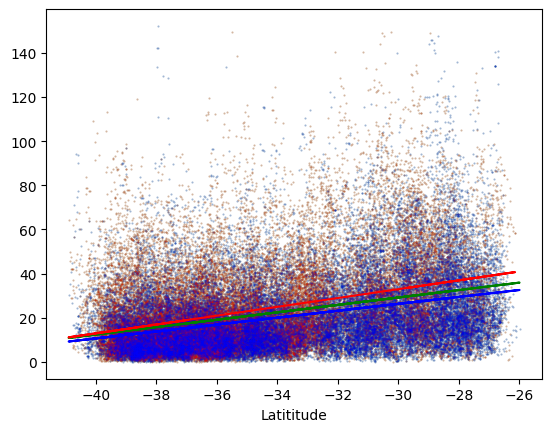

In [16]:
from scipy.stats import linregress

alpha = .2
colors = plt.get_cmap("tab10").colors

# ALL
df = df_eddies.copy().dropna()
y = df.TiltDis
x = df.Lat # f

# run regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("ALL")
print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r_value**2)
print("p-value:", p_value)
print("Standard error:", std_err)

# plot data + line
plt.scatter(x, y, s=1, marker='.', alpha=alpha, color='g')
plt.plot(x, slope*x + intercept, color='g')

# AE
df = df_eddies.copy().dropna()
df = df[df.Cyc=='AE']
y = df.TiltDis
x = df.Lat # f

# run regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("AE")
print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r_value**2)
print("p-value:", p_value)
print("Standard error:", std_err)

# plot data + line
plt.scatter(x, y, s=1, marker='.', alpha=alpha, color='r')
plt.plot(x, slope*x + intercept, color='r')

# CE
df = df_eddies.copy().dropna()
df = df[df.Cyc=='CE']
y = df.TiltDis
x = df.Lat # f

# run regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("CE")
print("Slope:", slope)
print("Intercept:", intercept)
print("R²:", r_value**2)
print("p-value:", p_value)
print("Standard error:", std_err)

# plot data + line
plt.scatter(x, y, s=1, marker='.', alpha=alpha, color='b')
plt.plot(x, slope*x + intercept, color='b')

plt.xlabel('Latititude')


0.0
0.0
0.0


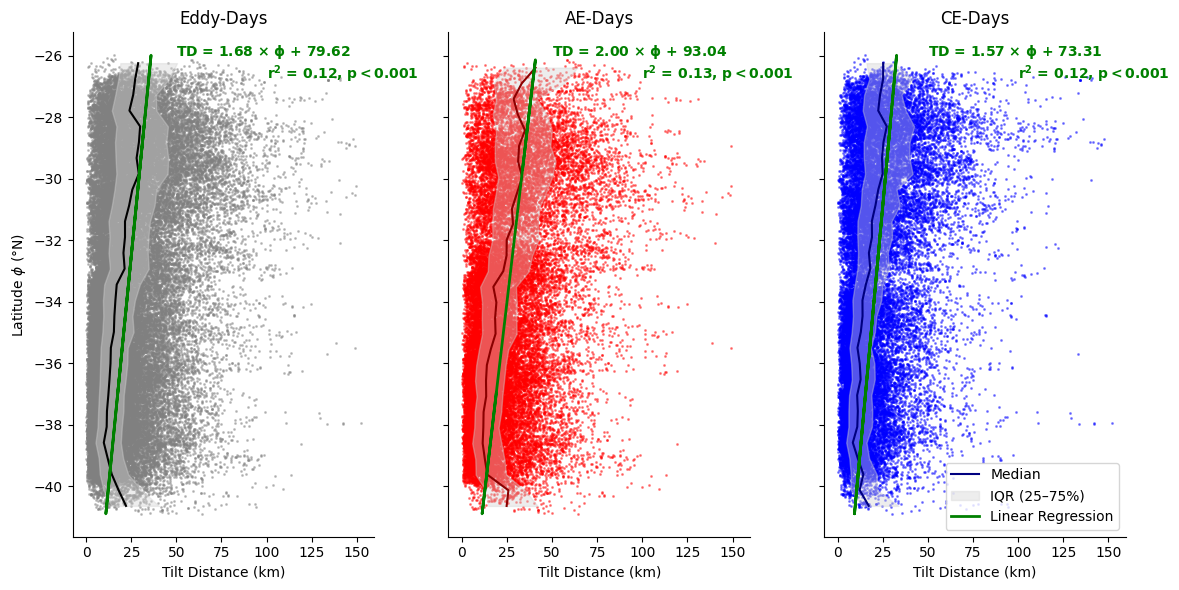

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12,6), sharey=True, sharex=True)

styles = {
    'Eddy-Days': {'scatter': 'grey',  'line': 'black', 'fill': 'lightgrey'},
    'AE-Days':  {'scatter': 'red',   'line': 'darkred', 'fill': 'lightgrey'},
    'CE-Days':  {'scatter': 'blue',  'line': 'navy', 'fill': 'lightgrey'}
}

for p, cyc in enumerate(['Eddy-Days', 'AE-Days', 'CE-Days']):
    if cyc == 'Eddy-Days':
        df_masked = df_eddies.copy().dropna()
    else:
        df_masked = df_eddies[df_eddies.Cyc==cyc[:2]].copy().dropna()
        
    x = df_masked['TiltDis']
    y = df_masked['Lat']
    
    bins = np.linspace(y.min(), y.max(), 30)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    digitized = np.digitize(y, bins)
    
    median = [x[digitized == i].median() for i in range(1, len(bins))]
    q25    = [x[digitized == i].quantile(0.25) for i in range(1, len(bins))]
    q75    = [x[digitized == i].quantile(0.75) for i in range(1, len(bins))]
    
    axs[p].scatter(x, y, marker='.', s=5, alpha=0.4, color=styles[cyc]['scatter'])
    axs[p].plot(median, bin_centers, color=styles[cyc]['line'], label='Median')
    axs[p].fill_betweenx(
        bin_centers,
        q25, q75,
        color=styles[cyc]['fill'],
        alpha=0.4,
        label='IQR (25–75%)'
    )

    y = df_masked['TiltDis']
    x = df_masked['Lat']

    # run regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    axs[p].plot(slope*x + intercept, x, color='g', lw=2, label='Linear Regression')
    axs[p].text(50, -26, fr'TD = {slope:.02f} $\mathbf{{\times}}$ $\mathbf{{\phi}}$ + {intercept:.02f}',
                color='g', fontweight='bold')
    axs[p].text(100, -26.75, fr'$\mathbf{{r^2}}$ = {r_value**2:.02f}, $\mathbf{{p < 0.001}}$',
                color='g', fontweight='bold')
    print(p_value)
    
    axs[p].set_xlabel('Tilt Distance (km)')
    axs[p].set_title(cyc)
    if p ==2:
        axs[p].legend(loc='lower right')
    axs[p].spines['top'].set_visible(False)
    axs[p].spines['right'].set_visible(False)

axs[0].set_ylabel(r'Latitude $\phi$ (°N)')
plt.tight_layout()
plt.show()


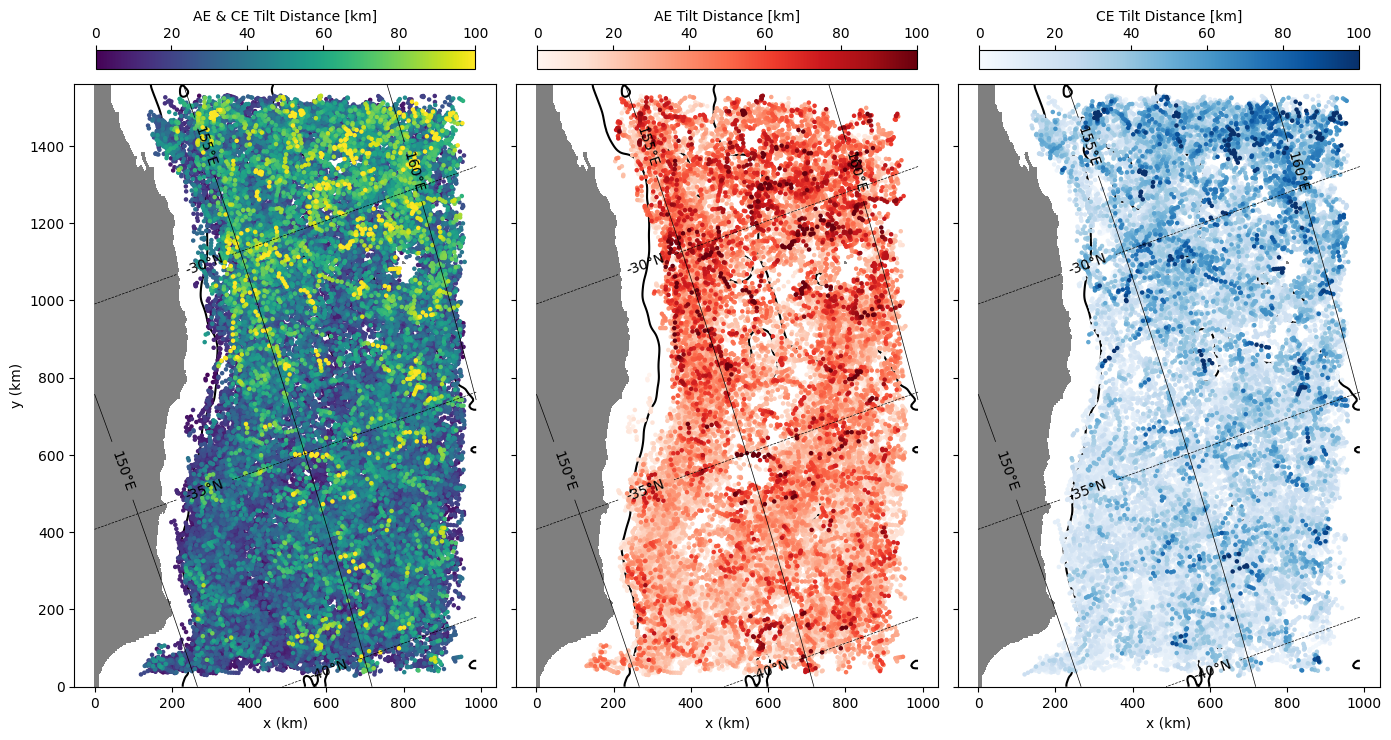

In [18]:
vmin, vmax = 0, 100
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize

norm = Normalize(vmin=vmin, vmax=vmax)
cmaps = {"AE & CE": "viridis", "AE": "Reds", "CE": "Blues"}

fig, axs = plt.subplots(1, 3, figsize=(14, 8), sharey=True)

for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]
    df = df.sort_values('TiltDis', kind='mergesort', ignore_index=True)

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    sc = ax.scatter(df.xc, df.yc, c=df.TiltDis, s=5, cmap=cmaps[cyc], norm=norm,
                    rasterized=True, zorder=2)
    cb = fig.colorbar(sc, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Tilt Distance [km]')
    cb.set_ticks(np.linspace(vmin, vmax, 6))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                          colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{v:.0f}°N", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                          colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()


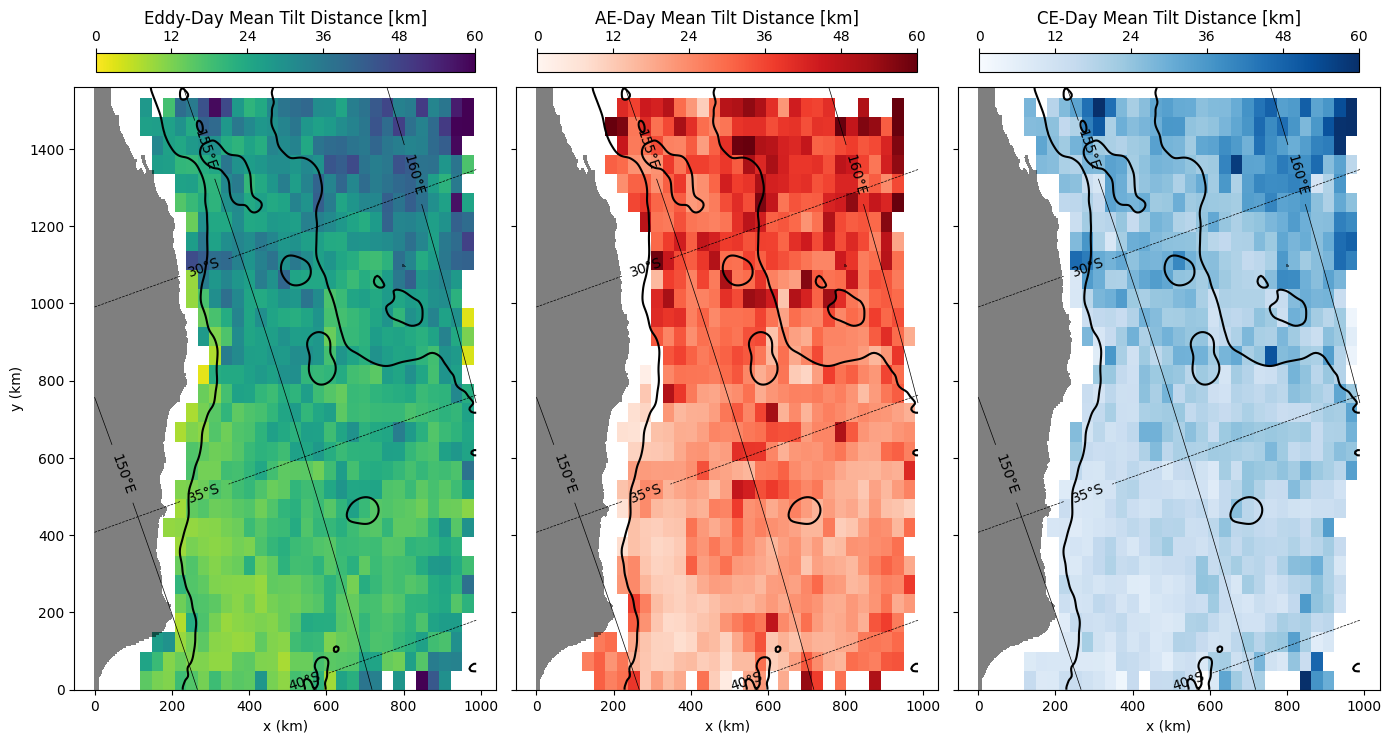

In [19]:
def _nice_step(h, base):
    s = h / base
    for k in [1, 2, 2.5, 5, 10]:
        if s <= k: return k * base
    return np.ceil(s) * base

def _grid_step(G):
    gx = np.diff(np.sort(np.unique(G.ravel())))
    return np.nanmedian(gx[gx > 0])

def _bin_edges_fd(x, grid, scale=1.0, rule='fd'):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 2:
        lo, hi = np.nanmin(x), np.nanmax(x)
        return np.array([lo, hi])
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    std = np.std(x, ddof=1)
    if rule.lower() == 'fd':
        bw = 2 * (iqr if iqr > 0 else 1.349 * std) / (n ** (1/3))
    else:
        bw = 3.5 * std / (n ** (1/3))
    if not np.isfinite(bw) or bw <= 0:
        rng = np.ptp(x)
        bw = rng / max(10, np.sqrt(n))
    base = _grid_step(grid)
    bw = _nice_step(scale * bw, base)
    lo = np.floor(np.nanmin(x) / bw) * bw
    hi = np.ceil(np.nanmax(x) / bw) * bw
    return np.arange(lo, hi + bw, bw)

# compute shared edges once for all panels
xbins = _bin_edges_fd(df_eddies.xc.values, X_grid, scale=1.0, rule='fd')
ybins = _bin_edges_fd(df_eddies.yc.values, Y_grid, scale=1.0, rule='fd')

vmin, vmax = 0, 60
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)
cmaps = {"Eddy-Day": "viridis_r", "AE-Day": "Reds", "CE-Day": "Blues"}

def binned_mean(x, y, v, xbins, ybins):
    ix = np.digitize(x, xbins) - 1
    iy = np.digitize(y, ybins) - 1
    nx, ny = len(xbins) - 1, len(ybins) - 1
    ok = (ix>=0)&(ix<nx)&(iy>=0)&(iy<ny)&np.isfinite(v)
    flat = iy[ok]*nx + ix[ok]
    s = np.bincount(flat, weights=v[ok], minlength=nx*ny)
    c = np.bincount(flat, minlength=nx*ny)
    hmean = np.full(nx*ny, np.nan)
    hmean[c>0] = s[c>0]/c[c>0]
    return hmean.reshape(ny, nx)

fig, axs = plt.subplots(1, 3, figsize=(14, 8), sharey=True)

for p, cyc in enumerate(['Eddy-Day', 'AE-Day', 'CE-Day']):
    ax = axs[p]
    df = df_eddies if cyc == 'Eddy-Day' else df_eddies[df_eddies.Cyc == cyc[:2]]
    df = df.sort_values('TiltDis', kind='mergesort', ignore_index=True)

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    H = binned_mean(df.xc.values, df.yc.values, df.TiltDis.values, xbins, ybins)
    m = ax.pcolormesh(xbins, ybins, H, cmap=cmaps[cyc], norm=norm, shading='auto', rasterized=True)
    cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Mean Tilt Distance [km]', fontsize=12)
    cb.set_ticks(np.linspace(vmin, vmax, 6))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()


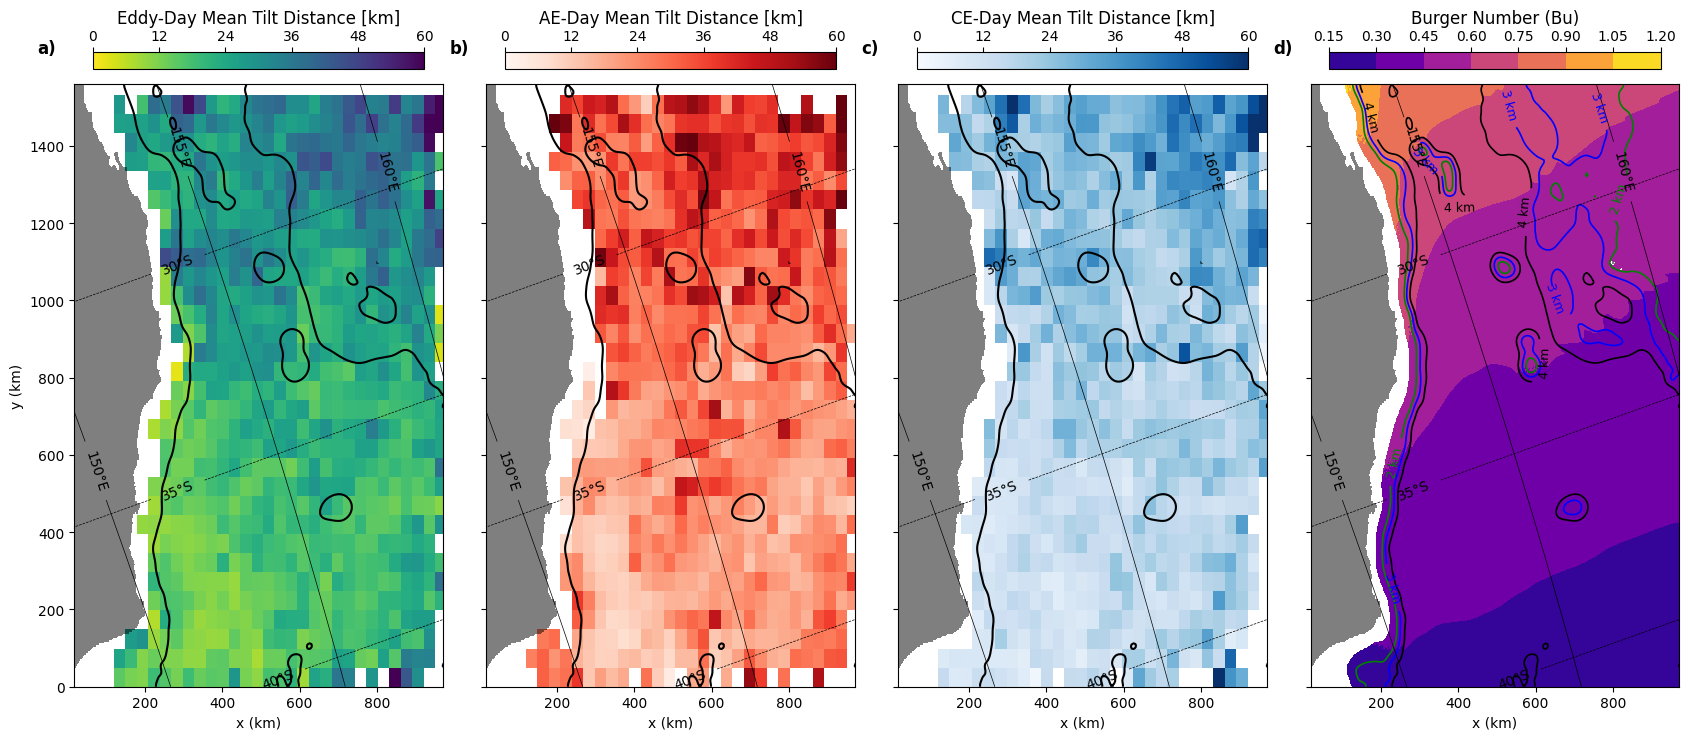

In [20]:
def _nice_step(h, base):
    s = h / base
    for k in [1, 2, 2.5, 5, 10]:
        if s <= k: return k * base
    return np.ceil(s) * base

def _grid_step(G):
    gx = np.diff(np.sort(np.unique(G.ravel())))
    return np.nanmedian(gx[gx > 0])

def _bin_edges_fd(x, grid, scale=1.0, rule='fd'):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 2:
        lo, hi = np.nanmin(x), np.nanmax(x)
        return np.array([lo, hi])
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    std = np.std(x, ddof=1)
    if rule.lower() == 'fd':
        bw = 2 * (iqr if iqr > 0 else 1.349 * std) / (n ** (1/3))
    else:
        bw = 3.5 * std / (n ** (1/3))
    if not np.isfinite(bw) or bw <= 0:
        rng = np.ptp(x)
        bw = rng / max(10, np.sqrt(n))
    base = _grid_step(grid)
    bw = _nice_step(scale * bw, base)
    lo = np.floor(np.nanmin(x) / bw) * bw
    hi = np.ceil(np.nanmax(x) / bw) * bw
    return np.arange(lo, hi + bw, bw)

# compute shared edges once for all panels
xbins = _bin_edges_fd(df_eddies.xc.values, X_grid, scale=1.0, rule='fd')
ybins = _bin_edges_fd(df_eddies.yc.values, Y_grid, scale=1.0, rule='fd')

vmin, vmax = 0, 60
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)
cmaps = {"Eddy-Day": "viridis_r", "AE-Day": "Reds", "CE-Day": "Blues"}

def binned_mean(x, y, v, xbins, ybins):
    ix = np.digitize(x, xbins) - 1
    iy = np.digitize(y, ybins) - 1
    nx, ny = len(xbins) - 1, len(ybins) - 1
    ok = (ix>=0)&(ix<nx)&(iy>=0)&(iy<ny)&np.isfinite(v)
    flat = iy[ok]*nx + ix[ok]
    s = np.bincount(flat, weights=v[ok], minlength=nx*ny)
    c = np.bincount(flat, minlength=nx*ny)
    hmean = np.full(nx*ny, np.nan)
    hmean[c>0] = s[c>0]/c[c>0]
    return hmean.reshape(ny, nx)

fig, axs = plt.subplots(1, 4, figsize=(17, 8), sharey=True)

for p, cyc in enumerate(['Eddy-Day', 'AE-Day', 'CE-Day']):
    ax = axs[p]
    df = df_eddies if cyc == 'Eddy-Day' else df_eddies[df_eddies.Cyc == cyc[:2]]
    df = df.sort_values('TiltDis', kind='mergesort', ignore_index=True)

    ax.contour(X_grid, Y_grid, h/1000, levels=[4], colors='k')

    H = binned_mean(df.xc.values, df.yc.values, df.TiltDis.values, xbins, ybins)
    m = ax.pcolormesh(xbins, ybins, H, cmap=cmaps[cyc], norm=norm, shading='auto', rasterized=True)
    cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Mean Tilt Distance [km]', fontsize=12)
    cb.set_ticks(np.linspace(vmin, vmax, 6))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

ax = axs[3]
H = 300
Nbar_ave = np.load('/srv/scratch/z5297792/Climatology/N2s/Nbar_300m_ave.npy')
f = np.transpose(dataset.variables['f'], axes=(1, 0))
Bu = ( (Nbar_ave * H) / (f * 50000) )**2
Bu = np.where(mask_rho, Bu, np.nan)
Bu = np.where(h > H, Bu, np.nan)
m = ax.contourf(X_grid, Y_grid, Bu, cmap='plasma')
cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
cb.set_label(f'Burger Number (Bu)', fontsize=12)
# ax.contour(X_grid, Y_grid, h, levels=[1000, 2000, 3000, 4000], colors='k')

cs = ax.contour(X_grid, Y_grid, h/1000, levels=[2, 3, 4],
                colors=['g', 'b', 'k'], linewidths=1.2)
ax.clabel(cs, inline=True, fontsize=9, fmt='%d km')
    
ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]
c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
ax.axis('equal')

tags = ['a)', 'b)', 'c)', 'd)']
for a, ax in enumerate(axs):
    ax.set_xlabel('x (km)')
    ax.text(-0.1, 1.05, tags[a], transform=ax.transAxes, fontsize=12, fontweight='bold')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()


p=0.0000e+00
p=0.0000e+00
p=0.0000e+00


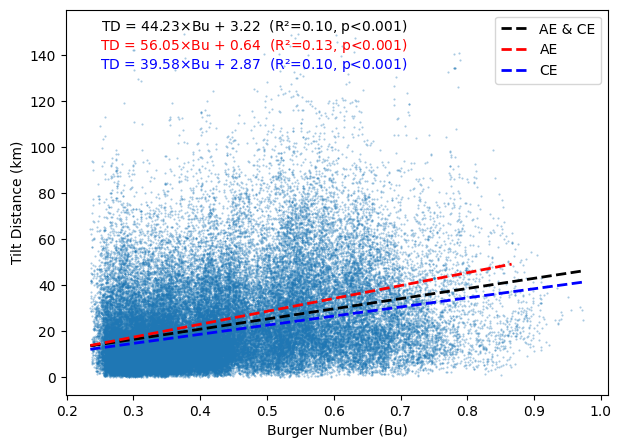

In [21]:
from scipy.stats import linregress

clrs = ['k', 'r', 'b']
lbls = ['AE & CE', 'AE', 'CE']

plt.figure(figsize=(7,5))

for k, df in enumerate([df_eddies, df_AE, df_CE]):

    x = Bu[df.ic, df.jc]
    y = df.TiltDis
    
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]

    res = linregress(x, y)
    slope, intercept, r, p = res.slope, res.intercept, res.rvalue, res.pvalue
    r2 = r**2

    # txt = fr"TD = {slope:.2f}$\times$Bu + {intercept:.2f}  (R²={r2:.2f}, p={p:.1e})"
    print(f'p={p:.4e}')
    txt = fr"TD = {slope:.2f}$\times$Bu + {intercept:.2f}  (R²={r2:.2f}, p<0.001)"
    plt.text(0.63, 0.98 - .05*k, txt, ha='right', va='top',
             color=clrs[k], transform=plt.gca().transAxes)

    idx = np.argsort(x)
    xs = x[idx]
    yp = slope*xs + intercept

    if k == 0:
        plt.scatter(x, y, marker='.', s=1, alpha=.4)

    plt.plot(xs, yp, color=clrs[k], lw=2, label=lbls[k], ls='--')

plt.xlabel('Burger Number (Bu)')
plt.ylabel('Tilt Distance (km)')
plt.legend()


/scratch/pbs.7190417.kman.restech.unsw.edu.au/ipykernel_2673771/3646928111.py:6: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label=r'Mean $\widebar{N}$ top 300m')


Text(0, 0.5, 'Latitude (°N)')

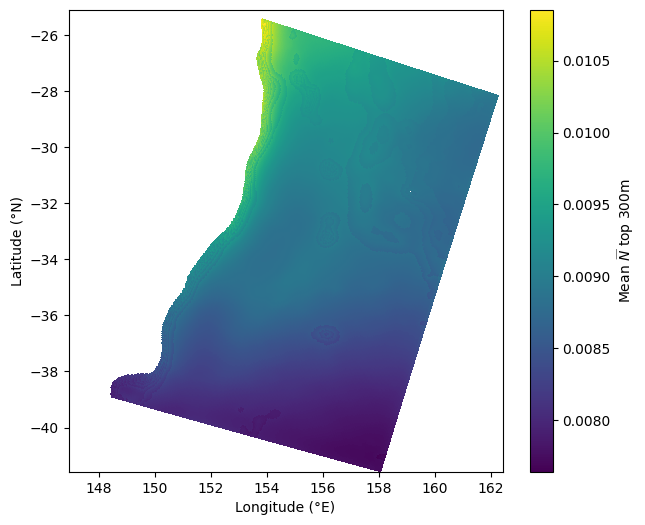

In [22]:
Nbar_ave = np.load('/srv/scratch/z5297792/Climatology/N2s/Nbar_300m_ave.npy')
plt.figure(figsize=(7,6))
field = np.where(h > 300, Nbar_ave, np.nan)
field = np.where(mask_rho, field, np.nan)
plt.pcolor(lon_rho, lat_rho, field)
plt.colorbar(label=r'Mean $\widebar{N}$ top 300m')
plt.axis('equal')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')


### Time Analysis

ALL
Slope: 1.3538966688670744
Intercept: 21.55244868457268
R²: 0.0003287578842786301
p-value: 6.924346436153854e-07
Standard error: 0.27274867836785166
AE
Slope: 0.15638399979957587
Intercept: 23.530585549430413
R²: 4.063542532516787e-06
p-value: 0.6906345923183395
Standard error: 0.3929276053104986
CE
Slope: 2.595618140639405
Intercept: 19.43960298139322
R²: 0.001346674668164598
p-value: 3.415718171344443e-12
Standard error: 0.3728341728731438


Text(0, 0.5, 'Tilt Distance (km)')

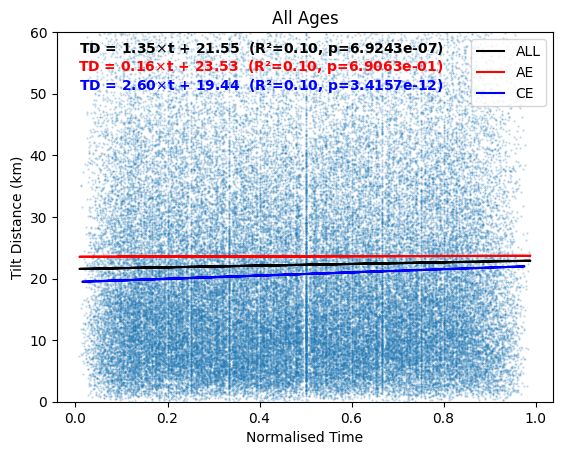

In [23]:
titles = ['ALL', 'AE', 'CE']
clrs = ['k', 'r', 'b']
for d, df_data in enumerate([df_eddies, df_AE, df_CE]):
    df_list = []
    for eddy in df_data.Eddy.unique():
        seg = df_data[df_data.Eddy == eddy]
        df_list.append(pd.DataFrame({
            'x': seg.norm_time,
            'y': seg.TiltDis
        }))
    
    df = pd.concat(df_list, ignore_index=True).dropna()
    x, y = df.x.values, df.y.values

    slope, intercept, r, p, err = linregress(x, y)
    print(f'{titles[d]}')
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R²: {r**2}")
    print(f"p-value: {p}")
    print(f"Standard error: {err}")

    if d == 0:
        plt.scatter(x, y, s=1, marker='.', alpha=.3)
    plt.plot(x, slope * x + intercept, color=clrs[d], label=f'{titles[d]}')

    txt = fr"TD = {slope:.2f}$\times$t + {intercept:.2f}  (R²={r2:.2f}, p={p:.4e})"
    plt.text(0.78, 0.98 - .05*d, txt, ha='right', va='top', fontweight='bold',
             color=clrs[d], transform=plt.gca().transAxes)

plt.ylim(0, 60); plt.legend(); plt.title('All Ages')
plt.xlabel('Normalised Time'); plt.ylabel('Tilt Distance (km)')


In [24]:
age_stops = list(np.arange(0, 151, 10)) + [500]

rows = []

for cyc_label, df_data in zip(['AE', 'CE'], [df_AE, df_CE]):
    for i, age1 in enumerate(age_stops):
        for age2 in age_stops[i+1:]:

            # enforce minimum width of 50 days
            if age2 - age1 < 50:
                continue

            sub = df_data[
                (df_data.Age >= age1) &
                (df_data.Age < age2)
            ][['Age', 'TiltDis', 'norm_time']].dropna()

            if len(sub) < 2:
                continue

            slope, intercept, r, p, err = linregress(
                sub.norm_time.values,
                sub.TiltDis.values
            )

            rows.append({
                'Cyc': cyc_label,
                'age1': age1,
                'age2': age2,
                'slope': slope,
                'intercept': intercept,
                'R2': r**2,
                'p': p,
                'err': err
            })

df_tilt_age_ints = pd.DataFrame(rows)
df_tilt_age_ints = df_tilt_age_ints[df_tilt_age_ints.age1 <= 100]
df_tilt_age_ints


Cyc  age1  age2     slope  intercept        R2         p       err
0    AE     0    50  0.881654  26.844580  0.000095  0.181485  0.659800
1    AE     0    60  1.688614  25.749220  0.000372  0.003668  0.581137
2    AE     0    70  1.768672  25.368390  0.000424  0.001084  0.541171
3    AE     0    80  1.674179  25.316880  0.000393  0.000964  0.507144
4    AE     0    90  1.695614  24.988308  0.000412  0.000456  0.483699
..   ..   ...   ...       ...        ...       ...       ...       ...
154  CE    90   140  0.487884  18.517008  0.000067  0.637909  1.036577
155  CE    90   150  0.135893  18.393754  0.000005  0.892042  1.001189
156  CE    90   500 -0.282146  17.376980  0.000026  0.734405  0.831569
157  CE   100   150  2.169013  17.077454  0.001649  0.073972  1.213263
158  CE   100   500  0.855669  15.968939  0.000305  0.349054  0.913611

[154 rows x 8 columns]

In [25]:
# Find max and min slopes
df_tilt_age_ints_AE = df_tilt_age_ints[df_tilt_age_ints.Cyc=='AE'].copy()
max_AE_slope = df_tilt_age_ints_AE.iloc[df_tilt_age_ints_AE.slope.abs().argmax()]
min_AE_slope = df_tilt_age_ints_AE.iloc[df_tilt_age_ints_AE.slope.abs().argmin()]

df_tilt_age_ints_CE = df_tilt_age_ints[df_tilt_age_ints.Cyc=='CE'].copy()
max_CE_slope = df_tilt_age_ints_CE.iloc[df_tilt_age_ints_CE.slope.abs().argmax()]
min_CE_slope = df_tilt_age_ints_CE.iloc[df_tilt_age_ints_CE.slope.abs().argmin()]


AE
Slope: 2.502530118092932
Intercept: 21.054407051661812
R²: 0.0012979565658566851
p-value: 2.7965525034694534e-05
Standard error: 0.5971387367453072
CE
Slope: 5.829224999988883
Intercept: 17.10981013481127
R²: 0.008317043984498639
p-value: 6.434904281720619e-31
Standard error: 0.5031197176085567


Text(0, 0.5, 'Tilt Distance (km)')

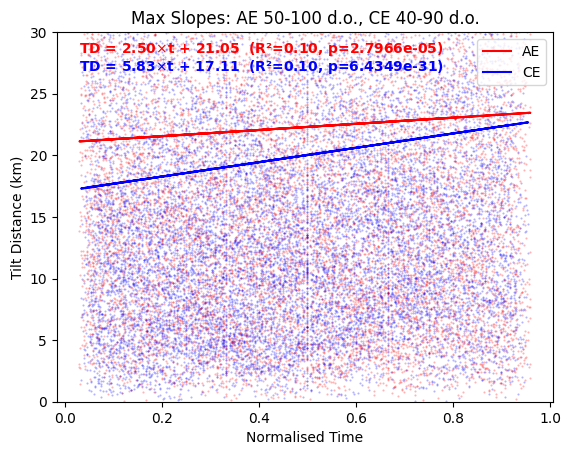

In [52]:
titles = ['AE', 'CE']
clrs = ['r', 'b']
for d, df_data in enumerate([df_AE, df_CE]):
    df_list = []
    for eddy in df_data.Eddy.unique():
        seg = df_data[df_data.Eddy == eddy]
        if seg.Cyc.iloc[0] =='AE':
            if (seg.Age.iloc[0] >= max_AE_slope.age1) & (seg.Age.iloc[0] <= max_AE_slope.age2):
                df_list.append(pd.DataFrame({
                    'x': seg.norm_time,
                    'y': seg.TiltDis
                }))
        else:
            if (seg.Age.iloc[0] >= max_CE_slope.age1) & (seg.Age.iloc[0] <= max_CE_slope.age2):
                df_list.append(pd.DataFrame({
                    'x': seg.norm_time,
                    'y': seg.TiltDis
                }))
    
    df = pd.concat(df_list, ignore_index=True).dropna()
    x, y = df.x.values, df.y.values

    slope, intercept, r, p, err = linregress(x, y)
    print(f'{titles[d]}')
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R²: {r**2}")
    print(f"p-value: {p}")
    print(f"Standard error: {err}")
   
    plt.scatter(x, y, s=1, marker='.', alpha=.3, color='r' if d==0 else 'b')
    plt.plot(x, slope * x + intercept, color=clrs[d], label=f'{titles[d]}')

    txt = fr"TD = {slope:.2f}$\times$t + {intercept:.2f}  (R²={r2:.2f}, p={p:.4e})"
    plt.text(0.78, 0.98 - .05*d, txt, ha='right', va='top', fontweight='bold',
             color=clrs[d], transform=plt.gca().transAxes)

plt.ylim(0, 30); plt.legend(loc='upper right'); 
plt.title(f'Max Slopes: AE {max_AE_slope.age1}-{max_AE_slope.age2} d.o., CE {max_CE_slope.age1}-{max_CE_slope.age2} d.o.')
plt.xlabel('Normalised Time'); plt.ylabel('Tilt Distance (km)')



Text(0.5, 0.98, 'Increasing TD Eddies')

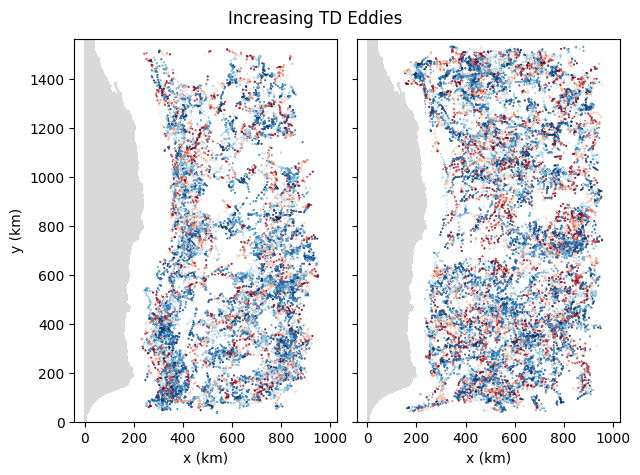

In [80]:
titles = ['AE', 'CE']
clrs = ['r', 'b']
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
axs[1].contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
for d, df_data in enumerate([df_AE, df_CE]):
    df_list = []
    for eddy in df_data.Eddy.unique():
        seg = df_data[df_data.Eddy == eddy]
        if seg.Cyc.iloc[0] =='AE':
            if (seg.Age.iloc[0] >= max_AE_slope.age1) & (seg.Age.iloc[0] <= max_AE_slope.age2):
                axs[0].scatter(seg.xc, seg.yc, marker='.', s=1, c=seg.TiltDis, cmap='RdBu_r') #color=clrs[d])
        else:
            if (seg.Age.iloc[0] >= max_CE_slope.age1) & (seg.Age.iloc[0] <= max_CE_slope.age2):
                axs[1].scatter(seg.xc, seg.yc, marker='.', s=1, c=seg.TiltDis, cmap='RdBu_r')#, color=clrs[d])

axs[0].axis('equal'); axs[1].axis('equal')
axs[0].set_ylabel('y (km)');
axs[0].set_xlabel('x (km)'); axs[1].set_xlabel('x (km)');
plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.suptitle('Increasing TD Eddies')


AE
Slope: 0.012994488053267117
Intercept: 20.97524001850578
R²: 3.726085651208205e-08
p-value: 0.9757323782301397
Standard error: 0.4271699235719645
CE
Slope: -0.5495747991035066
Intercept: 18.61834143713663
R²: 8.982700560419902e-05
p-value: 0.5715397947416178
Standard error: 0.9712588615833134


Text(0, 0.5, 'Tilt Distance (km)')

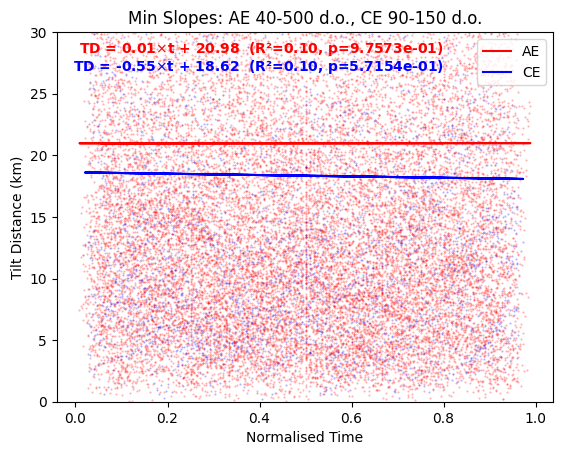

In [27]:
titles = ['AE', 'CE']
clrs = ['r', 'b']
for d, df_data in enumerate([df_AE, df_CE]):
    df_list = []
    for eddy in df_data.Eddy.unique():
        seg = df_data[df_data.Eddy == eddy]
        if seg.Cyc.iloc[0] =='AE':
            if (seg.Age.iloc[0] >= min_AE_slope.age1) & (seg.Age.iloc[0] <= min_AE_slope.age2):
                df_list.append(pd.DataFrame({
                    'x': seg.norm_time,
                    'y': seg.TiltDis
                }))
        else:
            if (seg.Age.iloc[0] >= min_CE_slope.age1) & (seg.Age.iloc[0] <= min_CE_slope.age2):
                df_list.append(pd.DataFrame({
                    'x': seg.norm_time,
                    'y': seg.TiltDis
                }))
    
    df = pd.concat(df_list, ignore_index=True).dropna()
    x, y = df.x.values, df.y.values

    slope, intercept, r, p, err = linregress(x, y)
    print(f'{titles[d]}')
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R²: {r**2}")
    print(f"p-value: {p}")
    print(f"Standard error: {err}")
   
    plt.scatter(x, y, s=1, marker='.', alpha=.3, color='r' if d==0 else 'b')
    plt.plot(x, slope * x + intercept, color=clrs[d], label=f'{titles[d]}')

    txt = fr"TD = {slope:.2f}$\times$t + {intercept:.2f}  (R²={r2:.2f}, p={p:.4e})"
    plt.text(0.78, 0.98 - .05*d, txt, ha='right', va='top', fontweight='bold',
             color=clrs[d], transform=plt.gca().transAxes)

plt.ylim(0, 30); plt.legend(loc='upper right'); 
plt.title(f'Min Slopes: AE {min_AE_slope.age1}-{min_AE_slope.age2} d.o., CE {min_CE_slope.age1}-{min_CE_slope.age2} d.o.')
plt.xlabel('Normalised Time'); plt.ylabel('Tilt Distance (km)')


Text(0.5, 0.98, 'Constant TD Eddies')

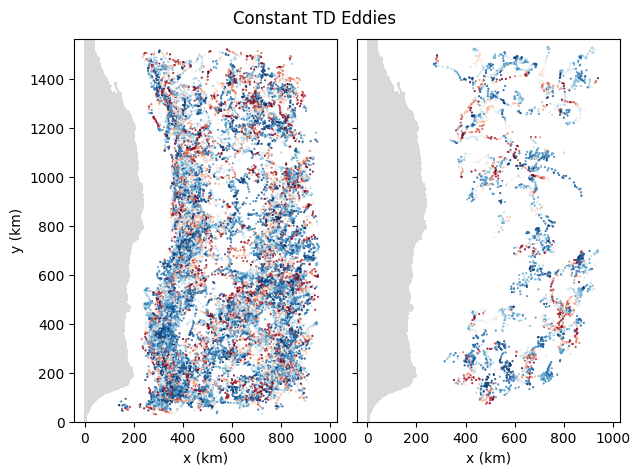

In [84]:
titles = ['AE', 'CE']
clrs = ['r', 'b']
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
axs[1].contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
for d, df_data in enumerate([df_AE, df_CE]):
    df_list = []
    for eddy in df_data.Eddy.unique():
        seg = df_data[df_data.Eddy == eddy]
        if seg.Cyc.iloc[0] =='AE':
            if (seg.Age.iloc[0] >= min_AE_slope.age1) & (seg.Age.iloc[0] <= min_AE_slope.age2):
                axs[0].scatter(seg.xc, seg.yc, marker='.', s=1, c=seg.TiltDis, cmap='RdBu_r')#, color=clrs[d])
        else:
            if (seg.Age.iloc[0] >= min_CE_slope.age1) & (seg.Age.iloc[0] <= min_CE_slope.age2):
                axs[1].scatter(seg.xc, seg.yc, marker='.', s=1, c=seg.TiltDis, cmap='RdBu_r')#, color=clrs[d])

axs[0].axis('equal'); axs[1].axis('equal')
axs[0].set_ylabel('y (km)');
axs[0].set_xlabel('x (km)'); axs[1].set_xlabel('x (km)');
plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.suptitle('Constant TD Eddies')


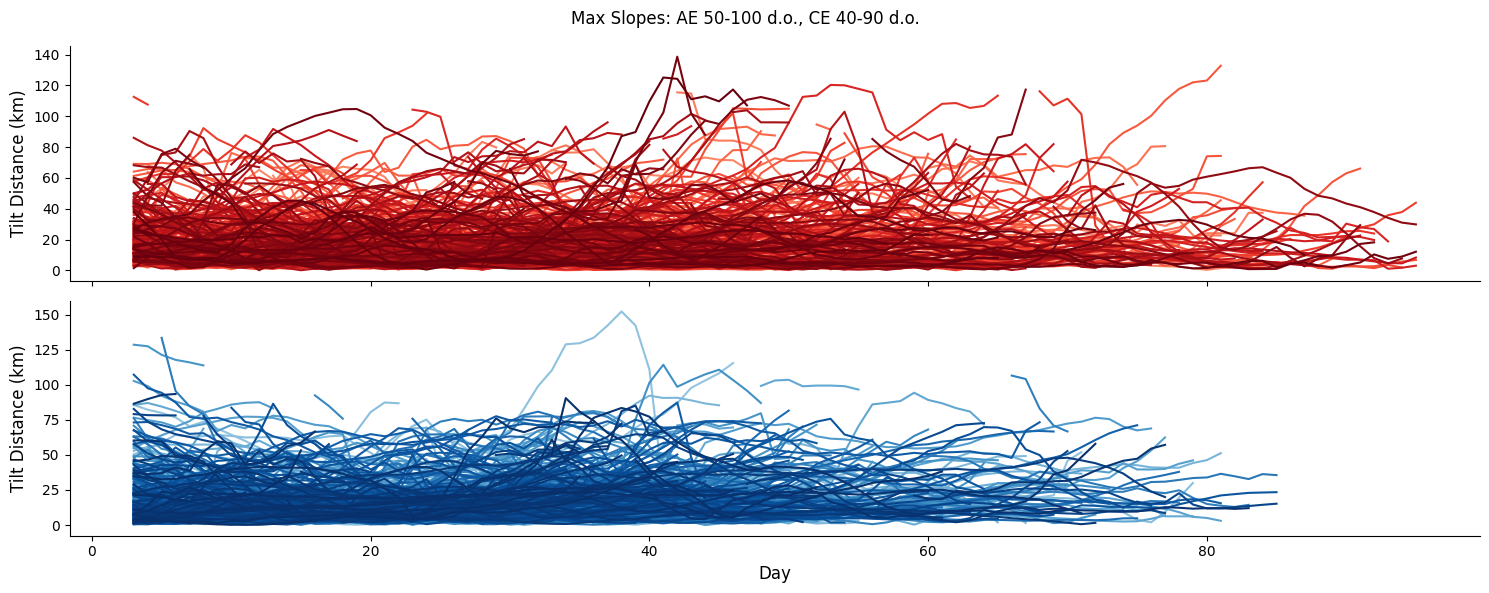

In [28]:
import matplotlib.cm as cm

ae = df_AE[(df_AE.Age >= max_AE_slope.age1)&(df_AE.Age <= max_AE_slope.age2)].Eddy.unique()
ce = df_CE[(df_CE.Age >= max_CE_slope.age1)&(df_CE.Age <= max_CE_slope.age2)].Eddy.unique()
# colour ranges
colors_ae = cm.Reds(np.linspace(0.4, 1, len(ae)))
colors_ce = cm.Blues(np.linspace(0.4, 1, len(ce)))

fig, axs = plt.subplots(2, 1, figsize=(15,6), sharex=True)
ae_idx, ce_idx = 0, 0
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if df.Cyc.iloc[0] == 'AE':
        if (df.Age.iloc[0] >= max_AE_slope.age1) & (df.Age.iloc[0] <= max_AE_slope.age2):
            axs[0].plot(np.arange(len(df)), df.TiltDis, color=colors_ae[ae_idx])
            # axs[0].set_xlabel('Day', fontsize=12)
            axs[0].set_ylabel('Tilt Distance (km)', fontsize=12)
            axs[0].spines['top'].set_visible(False)
            axs[0].spines['right'].set_visible(False)
            ae_idx += 1
    else:
        if (df.Age.iloc[0] >= max_CE_slope.age1) & (df.Age.iloc[0] <= max_CE_slope.age2):
            axs[1].plot(np.arange(len(df)), df.TiltDis, color=colors_ce[ce_idx])
            axs[1].set_xlabel('Day', fontsize=12)
            axs[1].set_ylabel('Tilt Distance (km)', fontsize=12)
            axs[1].spines['top'].set_visible(False)
            axs[1].spines['right'].set_visible(False)
            ce_idx += 1
plt.suptitle(f'Max Slopes: AE {max_AE_slope.age1}-{max_AE_slope.age2} d.o., CE {max_CE_slope.age1}-{max_CE_slope.age2} d.o.')
plt.tight_layout()


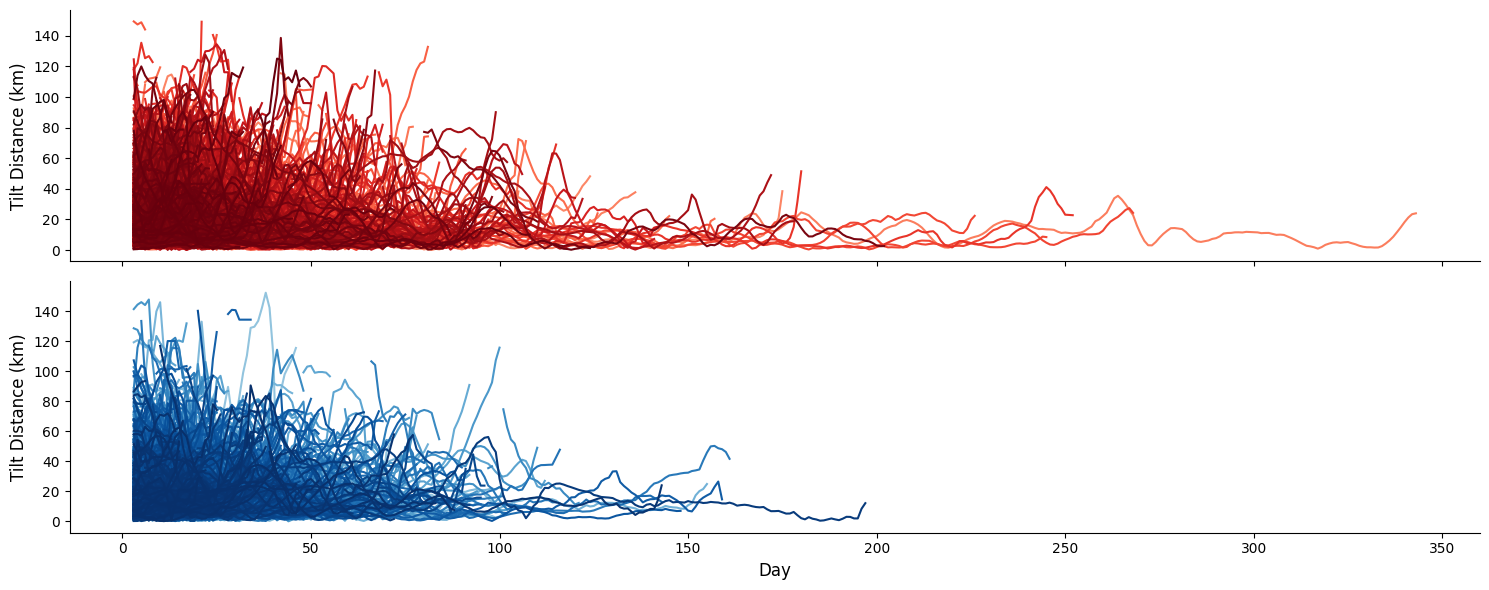

In [29]:
import matplotlib.cm as cm

ae = df_eddies[df_eddies.Cyc == 'AE'].Eddy.unique()
ce = df_eddies[df_eddies.Cyc == 'CE'].Eddy.unique()
# colour ranges
colors_ae = cm.Reds(np.linspace(0.4, 1, len(ae)))
colors_ce = cm.Blues(np.linspace(0.4, 1, len(ce)))

fig, axs = plt.subplots(2, 1, figsize=(15,6), sharex=True)
ae_idx, ce_idx = 0, 0
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if df.Cyc.iloc[0] == 'AE':
        axs[0].plot(np.arange(len(df)), df.TiltDis, color=colors_ae[ae_idx])
        # axs[0].set_xlabel('Day', fontsize=12)
        axs[0].set_ylabel('Tilt Distance (km)', fontsize=12)
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        ae_idx += 1
    else:
        axs[1].plot(np.arange(len(df)), df.TiltDis, color=colors_ce[ce_idx])
        axs[1].set_xlabel('Day', fontsize=12)
        axs[1].set_ylabel('Tilt Distance (km)', fontsize=12)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['right'].set_visible(False)
        ce_idx += 1
plt.tight_layout()

### Seasonality



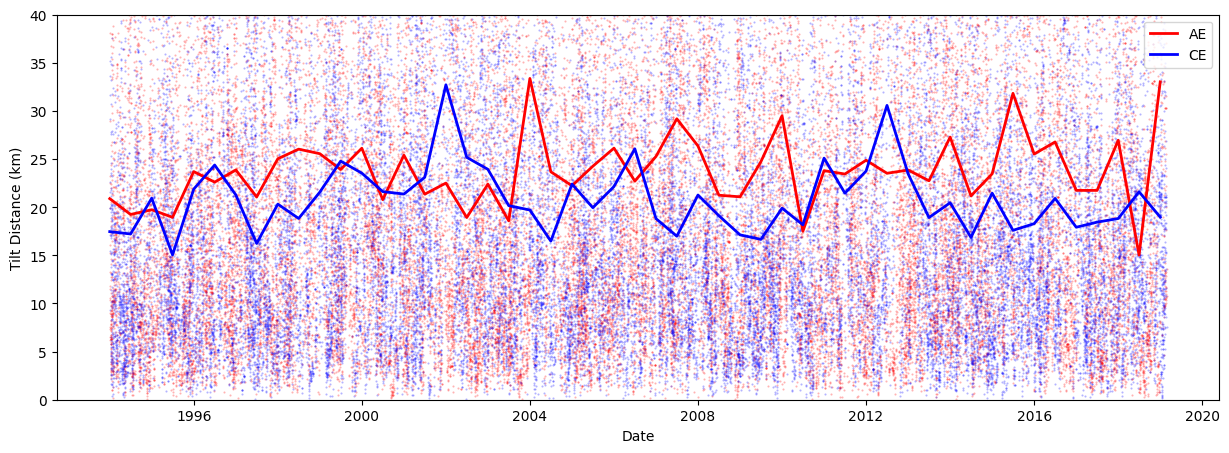

In [30]:
plt.figure(figsize=(15,5))

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    mean = df.groupby(pd.Grouper(key='Date', freq='6MS')).TiltDis.mean()
    # mean = df.groupby(pd.Grouper(key='Date', freq='1YE')).TiltDis.mean()
    plt.scatter(df.Date, df.TiltDis, s=1, alpha=0.3, color=c, marker='.')
    plt.plot(mean.index, mean.values, lw=2, color=c, label=label)

plt.xlabel('Date'); plt.legend()
plt.ylabel('Tilt Distance (km)')
plt.ylim(0, 40)
plt.show()


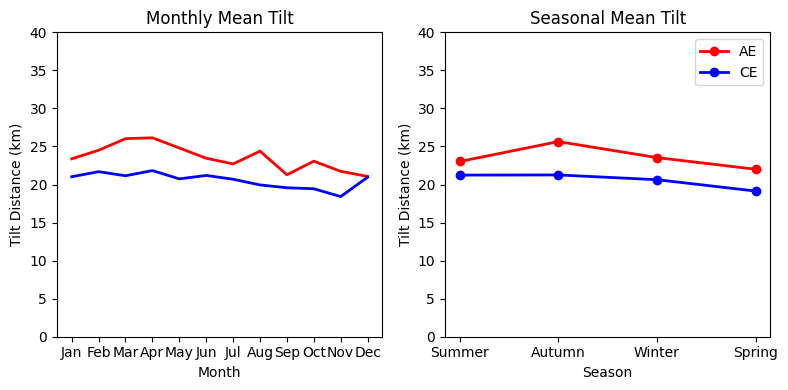

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))

# -------------------
# 1) MONTHLY PANEL
# -------------------
ax = axs[0]

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df['Month'] = df.Date.dt.month
    mean = df.groupby('Month').TiltDis.mean()
    ax.plot(mean.index, mean.values, lw=2, color=c)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 40)
ax.set_title('Monthly Mean Tilt')

# -------------------
# 2) SEASONAL PANEL
# -------------------
ax = axs[1]

season_map = {
    12:'Summer',1:'Summer',2:'Summer',
    3:'Autumn',4:'Autumn',5:'Autumn',
    6:'Winter',7:'Winter',8:'Winter',
    9:'Spring',10:'Spring',11:'Spring'
}
season_order = ['Summer','Autumn','Winter','Spring']

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Season'] = df_['Date'].dt.month.map(season_map)
    df_['Season'] = pd.Categorical(df_['Season'], categories=season_order, ordered=True)

    mean = (
        df_.groupby('Season', observed=True)
            .TiltDis.mean()
            .reindex(season_order)
    )
    x = np.arange(len(season_order))
    ax.plot(x, mean.values, lw=2, marker='o', color=c, label=label)

ax.set_xticks(x)
ax.set_xticklabels(season_order)
ax.set_xlabel('Season')
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 40)
ax.set_title('Seasonal Mean Tilt')
ax.legend()

plt.tight_layout()
plt.show()


### Temperature

### Windrose

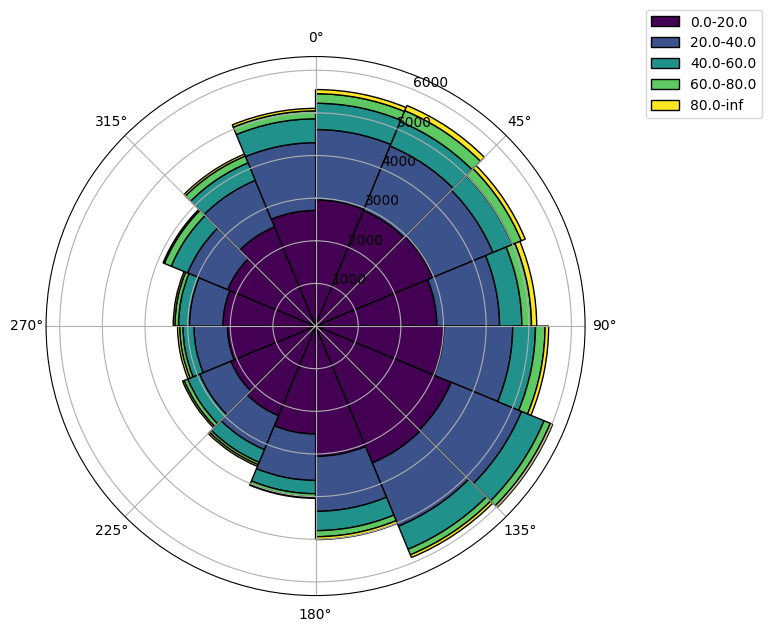

In [32]:
# Replace these with your actual data arrays
directions = df_eddies.TiltDir
magnitudes = df_eddies.TiltDis

# Define bins
dir_bins = np.linspace(0, 360, 17)  # 16 directional sectors
# mag_bins = np.linspace(magnitudes.min(), magnitudes.max(), 5)  # 4 strength categories
mag_bins = [0, 20, 40, 60, 80, np.inf]

# Digitise
dir_idx = np.digitize(directions, dir_bins) - 1
mag_idx = np.digitize(magnitudes, mag_bins) - 1

# Count occurrences per bin
counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
for d, m in zip(dir_idx, mag_idx):
    if 0 <= d < len(dir_bins)-1 and 0 <= m < len(mag_bins)-1:
        counts[m, d] += 1

# Prepare polar plot
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / n_dirs
bottom = np.zeros(n_dirs)
colors = plt.cm.viridis(np.linspace(0, 1, len(mag_bins)-1))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7,7))
for i in range(len(mag_bins)-1):
    ax.bar(angles, counts[i], width, bottom=bottom,
           color=colors[i], edgecolor='k',
           label=f'{mag_bins[i]:.1f}-{mag_bins[i+1]:.1f}')
    bottom += counts[i]

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))
plt.show()


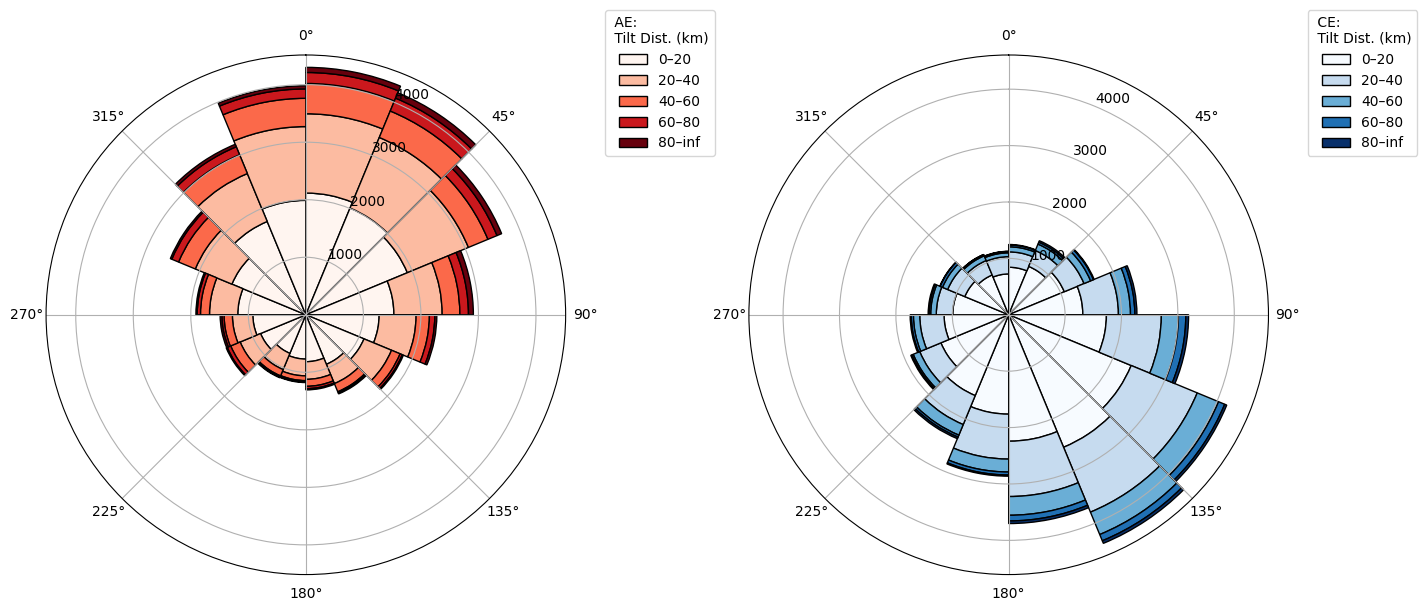

In [33]:
# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 20, 40, 60, 80, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    directions = df.TiltDir
    magnitudes = df.TiltDis

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors1[i] if a==0 else colors2[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    # ax.set_title(f'{title}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Tilt Dist. (km)')

# One legend for both
plt.show()


In [34]:
ae = df_AE_
north = ae[(ae.TiltDir < 90) | (ae.TiltDir > 270)]
north_east = ae[ae.TiltDir < 90]

print('% of AEs tilted northward:')
print(len(north) / len(ae))

print('% of AEs tilted northward with easterly component:')
print(len(north_east) / len(north))

print('% of TD between 0–40 km for northward tilts:')
print((north.TiltDis <= 40).mean())


% of AEs tilted northward:
0.6855295898212042
% of AEs tilted northward with easterly component:
0.564099685675797
% of TD between 0–40 km for northward tilts:
0.8210597215985631


In [35]:
ce = df_CE_
south = ce[(ce.TiltDir > 90) & (ce.TiltDir < 270)]
south_east = ce[(ce.TiltDir > 90) & (ce.TiltDir < 180)]

print('% of CEs tilted southward:')
print(len(south) / len(ce))

print('% of CEs tilted southward with easterly component:')
print(len(south_east) / len(south))

print('% of TD between 0–40 km for southward tilts:')
print((south.TiltDis <= 40).mean())


% of CEs tilted southward:
0.6768862675272647
% of CEs tilted southward with easterly component:
0.6355939169749281
% of TD between 0–40 km for southward tilts:
0.8749280723386765


### Eddy Propogation

Text(0, 0.5, 'Tilt Distance (km)')

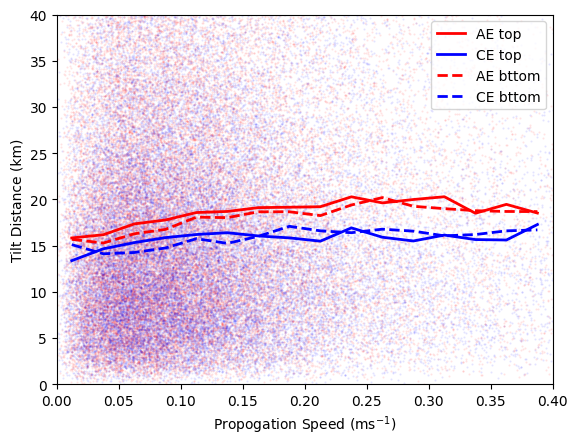

In [138]:
bins = np.arange(0, 0.4 + 0.025, 0.025)

# --- FIRST SET: EddyProp binned vs TiltDis ---
for d, (cyc, df) in enumerate([('AE', df_AE), ('CE', df_CE)]):
    df = df.copy()
    df['bin'] = pd.cut(df.EddyProp, bins=bins, include_lowest=True)
    mean = df.groupby('bin', observed=False).TiltDis.median()
    x = [b.mid for b in mean.index]
    
    plt.scatter(df.EddyProp, df.TiltDis, s=1, alpha=0.1,
                color='r' if d==0 else 'b', marker='.')
    plt.plot(x, mean.values, lw=2, label=f'{cyc} top', 
             color='r' if d==0 else 'b', linestyle='-')

# --- SECOND SET: btm_prop binned vs TiltDis (dashed) ---
for d, (cyc, df) in enumerate([('AE', df_AE), ('CE', df_CE)]):
    df = df.copy()
    df['bin'] = pd.cut(df.btm_prop, bins=bins, include_lowest=True)
    mean = df.groupby('bin', observed=False).TiltDis.median()
    x = [b.mid for b in mean.index]
    
    plt.plot(x, mean.values, lw=2, label=f'{cyc} bttom', 
             color='r' if d==0 else 'b', linestyle='--')

plt.xlim(0, 0.4); plt.ylim(0, 40); plt.legend()
plt.xlabel(r'Propogation Speed (ms$^{-1}$)')
plt.ylabel('Tilt Distance (km)')


In [95]:
print(f'On ave the bottom moved {(df_eddies.btm_prop - df_eddies.EddyProp).mean():02f} m/s faster then the top')

print(f'AE: {(df_AE.btm_prop - df_AE.EddyProp).mean():02f} m/s')
print(f'CE: {(df_CE.btm_prop - df_CE.EddyProp).mean():02f} m/s')


On ave the bottom moved 0.148525 m/s faster then the top
AE: 0.157194 m/s
CE: 0.138642 m/s


#### Vorticity

Text(0, 0.5, 'Tilt Distance (km)')

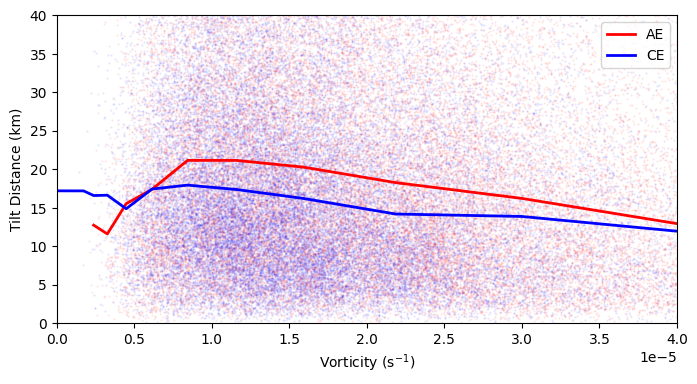

In [146]:
w = df_eddies.w.abs()
bins = np.logspace(np.log10(w[w>0].min()), np.log10(w.max()), 15)

plt.figure(figsize=(8,4))
for d, (cyc, df) in enumerate([('AE', df_AE), ('CE', df_CE)]):
    df = df.copy()
    df['bin'] = pd.cut(df.w.abs(), bins=bins, include_lowest=True)
    mean = df.groupby('bin', observed=False).TiltDis.median()
    x = [b.mid for b in mean.index]
    
    plt.scatter(df.w.abs(), df.TiltDis, s=1, alpha=0.1,
                color='r' if d==0 else 'b', marker='.')
    plt.plot(x, mean.values, lw=2, label=f'{cyc}', 
             color='r' if d==0 else 'b', linestyle='-')

plt.ylim(0, 40); plt.legend(loc='upper right')
plt.xlim(0, 4e-5);
plt.xlabel(r'Vorticity (s$^{-1}$)')
plt.ylabel('Tilt Distance (km)')



Text(0, 0.5, 'Tilt Distance (km)')

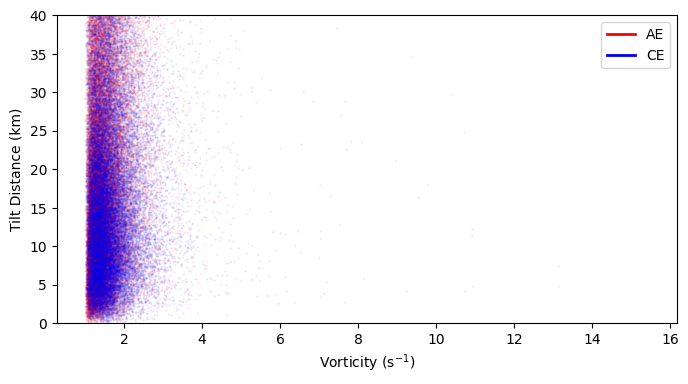

In [142]:
w = df_eddies.w.abs()
bins = np.logspace(np.log10(w[w>0].min()), np.log10(w.max()), 15)

plt.figure(figsize=(8,4))
for d, (cyc, df) in enumerate([('AE', df_AE), ('CE', df_CE)]):
    df = df.copy()
    df['bin'] = pd.cut(df.AR, bins=bins, include_lowest=True)
    mean = df.groupby('bin', observed=False).TiltDis.median()
    x = [b.mid for b in mean.index]
    
    plt.scatter(df.AR, df.TiltDis, s=1, alpha=0.1,
                color='r' if d==0 else 'b', marker='.')
    plt.plot(x, mean.values, lw=2, label=f'{cyc}', 
             color='r' if d==0 else 'b', linestyle='-')

plt.ylim(0, 40); plt.legend(loc='upper right')
plt.xlabel(r'Vorticity (s$^{-1}$)')
plt.ylabel('Tilt Distance (km)')


In [ ]:
df_eddies['h'] = h[df_eddies.ic, df_eddies.jc]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for p, cyc in enumerate(['AE', 'CE']):
    df = df_eddies[df_eddies.Cyc == cyc].copy()
    axs[p].scatter(df.h/1000, df.TiltDis, marker='.', color='r' if p == 0 else 'b', s=1, alpha=.1)

    bins = np.linspace((df.h/1000).min(), (df.h/1000).max(), 20)
    groups = df.groupby(pd.cut(df.h/1000, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('Bathymetry (km)')
    if p == 0:
        axs[p].set_ylabel('Tilt Distance')

plt.tight_layout()


In [ ]:
def slope_mag(h, X, Y, mask=None):
    # derivatives wrt index space (i, j)
    x_i, x_j = np.gradient(X)
    y_i, y_j = np.gradient(Y)
    h_i, h_j = np.gradient(h)

    # Jacobian and physical-space gradients
    J = x_i*y_j - x_j*y_i
    dhdx = ( h_i*y_j - h_j*y_i) / J
    dhdy = (-h_i*x_j + h_j*x_i) / J

    S = np.hypot(dhdx, dhdy)          # slope magnitude = tan(theta)
    S[np.isclose(J, 0)] = np.nan       # guard against singular cells
    if mask is not None:               # mask: 1=ocean, 0=land
        S = np.where(mask.astype(bool), S, np.nan)
    return S

s = slope_mag(h/1000, X_grid, Y_grid, mask=mask_rho)

df_eddies['s'] = s[df_eddies.ic, df_eddies.jc]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].pcolor(lon_rho, lat_rho, s)
axs[0].axis('equal')

for p, cyc in enumerate(['AE', 'CE']):
    p += 1
    df = df_eddies[df_eddies.Cyc == cyc].copy()
    axs[p].scatter(df.s, df.TiltDis, marker='.', color='r' if p == 1 else 'b', s=1, alpha=.1)

    bins = np.linspace(df.s.min(), df.s.max(), 20)
    groups = df.groupby(pd.cut(df.s, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('Magnitude of Bottom Slope')
    axs[p].set_ylabel('Tilt Distance')
    axs[p].set_ylim(-10, 160)
    axs[p].set_xlim(-.005, .150)

plt.tight_layout()



In [ ]:
def eccentricity_from_Q(Q, definition="eccentricity"):
    eigvals = np.linalg.eigvalsh(Q)
    a = 1 / np.sqrt(eigvals.min())
    b = 1 / np.sqrt(eigvals.max())
    
    if definition == "axis_ratio":
        return a / b
    elif definition == "ellipticity":
        return 1 - b / a
    elif definition == "eccentricity":
        return np.sqrt(1 - (b/a)**2)
    else:
        raise ValueError("Unknown definition")

df_eddies['Eccent'] = df_eddies.apply(
    lambda row: eccentricity_from_Q(
        np.array([[np.abs(row.q11), row.q12],
                  [row.q12, np.abs(row.q22)]]), definition='axis_ratio'
    ),
    axis=1
)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for p, cyc in enumerate(['AE', 'CE']):
    df = df_eddies[df_eddies.Cyc == cyc].copy()
    axs[p].scatter(df.Eccent, df.TiltDis, marker='.', color='r' if p == 0 else 'b', s=1, alpha=.1)

    bins = np.linspace(0, 1, 20)
    groups = df.groupby(pd.cut(df.Eccent, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlim(0, 1)
    axs[p].set_xlabel('Eccentricity')
    if p == 0:
        axs[p].set_ylabel('Tilt Distance')

plt.tight_layout()




In [ ]:
df_eddies['Date'] = pd.Timestamp('1990-01-01') + pd.to_timedelta(df_eddies.Day, unit='D')

plt.figure(figsize=(14, 4))
clrs = np.where(df_eddies.Cyc == 'CE', 'b', 'r')
plt.scatter(df_eddies.Date, df_eddies.TiltDis, c=clrs, marker='.', s=15, alpha=0.1)

trend_results = {}
for cyc, colour in [('AE', 'red'), ('CE', 'b')]:
    df_masked = df_eddies[df_eddies.Cyc == cyc]
    grouped = df_masked.groupby(df_masked['Date'].dt.to_period('M'))['TiltDis']
    monthly_mean = grouped.mean()
    monthly_std = grouped.std()
    monthly_mean.index = monthly_mean.index.to_timestamp()
    monthly_std.index = monthly_std.index.to_timestamp()

    plt.plot(monthly_mean.index, monthly_mean, marker='o', color=colour, label=cyc)
    plt.fill_between(monthly_mean.index,
                     monthly_mean - monthly_std,
                     monthly_mean + monthly_std,
                     color=colour, alpha=0.15)

    coeffs = np.polyfit(np.arange(len(monthly_mean)), monthly_mean, 1)
    trend_results[cyc] = coeffs[0]

plt.xlabel('Date')
plt.ylabel('Tilt Distance (Monthly Mean ± STD)')
plt.legend()
plt.tight_layout()

print(f"AE: {'Increasing' if trend_results['AE'] > 0 else 'Decreasing'} {trend_results['AE']*12*1000:.1f} m per year")
print(f"CE: {'Increasing' if trend_results['CE'] > 0 else 'Decreasing'} {trend_results['CE']*12*1000:.1f} m per year")



In [ ]:
df_eddies['Date'] = pd.Timestamp('1990-01-01') + pd.to_timedelta(df_eddies.Day, unit='D')

fig, axs = plt.subplots(2, 1, figsize=(14, 6))
clrs = np.where(df_eddies.Cyc == 'CE', 'b', 'r')

trend_results = {}
for p, (cyc, colour) in enumerate([('AE', 'red'), ('CE', 'b')]):
    df_masked = df_eddies[df_eddies.Cyc == cyc]
    axs[p].scatter(df_eddies.Date, df_eddies.TiltDis, c=colour, marker='.', s=15, alpha=0.1)
    grouped = df_masked.groupby(df_masked['Date'].dt.to_period('M'))['TiltDis']
    monthly_mean = grouped.mean()
    monthly_std = grouped.std()
    monthly_mean.index = monthly_mean.index.to_timestamp()
    monthly_std.index = monthly_std.index.to_timestamp()

    axs[p].plot(monthly_mean.index, monthly_mean, marker='o', color=colour, label=cyc)
    axs[p].fill_between(monthly_mean.index,
                     monthly_mean - monthly_std,
                     monthly_mean + monthly_std,
                     color='k', alpha=0.25)

    coeffs = np.polyfit(np.arange(len(monthly_mean)), monthly_mean, 1)
    trend_results[cyc] = coeffs[0]
    axs[p].legend()

plt.xlabel('Date')
plt.ylabel('Tilt Distance (Monthly Mean ± STD)')
plt.tight_layout()

print(f"AE: {'Increasing' if trend_results['AE'] > 0 else 'Decreasing'} {trend_results['AE']*12*1000:.1f} m per year")
print(f"CE: {'Increasing' if trend_results['CE'] > 0 else 'Decreasing'} {trend_results['CE']*12*1000:.1f} m per year")



In [ ]:
df_eddies['Date'] = pd.Timestamp('1990-01-01') + pd.to_timedelta(df_eddies.Day, unit='D')

plt.figure(figsize=(14, 4))
m = df_eddies['Date'].dt.month
clrs = np.where(df_eddies.Cyc == 'CE', 'b', 'r')
plt.scatter(m, df_eddies.TiltDis, c=clrs, marker='.', s=15, alpha=0.1)

for cyc, colour in [('AE', 'red'), ('CE', 'b')]:
    d = df_eddies[df_eddies.Cyc == cyc]
    s = d.groupby(d['Date'].dt.month)['TiltDis'].mean().reindex(range(1, 13))
    x = np.r_[s.index, 13]
    y = np.r_[s.values, s.iloc[0]]
    plt.plot(x, y, marker='o', color=colour, label=cyc)

plt.xlim(.5, 13.5)
plt.xticks(range(1, 13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Month')
plt.ylabel('Tilt Distance (Monthly Mean)')
plt.legend()
plt.tight_layout()


In [ ]:
df = df_eddies.copy()
df['Date'] = pd.Timestamp('1990-01-01') + pd.to_timedelta(df.Day, unit='D')
season_map = {12:'Summer',1:'Summer',2:'Summer',3:'Autumn',4:'Autumn',5:'Autumn',6:'Winter',7:'Winter',8:'Winter',9:'Spring',10:'Spring',11:'Spring'}
order = ['Summer','Autumn','Winter','Spring']
df['Season'] = pd.Categorical(df['Date'].dt.month.map(season_map), categories=order, ordered=True)

plt.figure(figsize=(10,4))
x_scatter = df['Season'].cat.codes + 1
clrs = np.where(df.Cyc=='CE','b','r')
plt.scatter(x_scatter, df.TiltDis, c=clrs, s=15, alpha=0.1)

for cyc, colour in [('AE','red'), ('CE','b')]:
    s = df[df.Cyc == cyc].groupby('Season', observed=False)['TiltDis'].mean().reindex(order)
    x = np.arange(1, 5)
    plt.plot(x, s.values, marker='o', color=colour, label=cyc)

plt.xticks(np.arange(1,5), order)
plt.xlabel('Season')
plt.ylabel('Tilt Distance (Seasonal Mean)')
plt.legend()
plt.tight_layout()




In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Example data (replace with actual df data)
eddy_prop = np.array(df_eddies.Eccent)
df_TiltDis = df_eddies.TiltDis

mask = ~np.isnan(eddy_prop) & ~np.isnan(df_TiltDis)
X = eddy_prop[mask].reshape(-1, 1)
y = df_TiltDis[mask]

model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

plt.scatter(X, y, marker='.', s=15)
plt.plot(X, y_pred, color='red', linewidth=2) 
# plt.xlabel('Eddy Propagation (m/s)')
plt.ylabel('Tilt Distance')
plt.title(f'Best Fit Line (R² = {r2:.3f})')
plt.show()


### Tilt Direction

In [ ]:
df_eddies

In [ ]:
plt.scatter(df_eddies.TiltDis, df_eddies.TiltDir, marker='.', s=1)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

def pingpong_cmap(color_a, color_b, name='pingpong', N=256, mid=0.5):
    return LinearSegmentedColormap.from_list(
        name, [(0.0, color_a), (mid, color_b), (1.0, color_a)], N=N
    )

# examples
cmap_bw = pingpong_cmap('black', 'yellow') 


In [ ]:
vmin, vmax = None, None
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize

norm = Normalize(vmin=vmin, vmax=vmax)
# cmaps = {"AE & CE": "viridis", "AE": "Reds", "CE": "Blues"}
cmaps = {"AE & CE": cmap_bw, "AE": cmap_bw, "CE": cmap_bw}

fig, axs = plt.subplots(1, 3, figsize=(14, 8), sharey=True)

for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]
    df = df.sort_values('TiltDir', kind='mergesort', ignore_index=True)#, ascending=False)

    sc = ax.scatter(df.xc, df.yc, c=df.TiltDir, s=1, cmap=cmaps[cyc], norm=norm,
                    rasterized=True, zorder=2)
    cb = fig.colorbar(sc, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Tilt Distance [km]')
    # cb.set_ticks(np.linspace(vmin, vmax, 6))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                          colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{v:.0f}°N", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                          colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()


In [ ]:
plt.contourf(X_grid, Y_grid, h, cmap='Grays')
plt.contour(X_grid, Y_grid, h, levels=[4000], colors='r')
plt.axis('equal')

plt.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                  levels=[0.5, 1.5], colors=['k'], alpha=.5)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Tilt Distance ---
axs[0].hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDis.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDis.dropna(), bins=100)
axs[0].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
axs[0].set_ylim(-2200, 2200)
axs[0].axhline(0, color='k', linewidth=1)
axs[0].set_xlabel('Tilt Distance (km)')
axs[0].set_ylabel('Number of Eddy-Days')
yticks = axs[0].get_yticks()
axs[0].set_yticks(yticks)
axs[0].set_yticklabels([abs(int(t)) for t in yticks])

# --- Tilt Direction ---
axs[1].hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDir.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDir.dropna(), bins=100)
axs[1].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
axs[1].set_ylim(-1000, 1000)
axs[1].axhline(0, color='k', linewidth=1)
axs[1].set_xlabel('Tilt Direction (° True North)')
axs[1].set_ylabel('Number of Eddy-Days')
yticks = axs[1].get_yticks()
axs[1].set_yticks(yticks)
axs[1].set_yticklabels([abs(int(t)) for t in yticks])

plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

dir_bins = np.linspace(0, 360, 9)
mag_bins = [0, 20, 40, 60, 80, np.inf]
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2*np.pi / n_dirs
colors_cmps = [plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))]

def windrose_counts(directions, magnitudes):
    if len(directions) == 0: return None
    d = np.digitize(np.mod(directions, 360), dir_bins) - 1
    m = np.digitize(magnitudes, mag_bins) - 1
    c = np.zeros((len(mag_bins)-1, n_dirs))
    for di, mi in zip(d, m):
        if 0 <= di < n_dirs and 0 <= mi < len(mag_bins)-1:
            c[mi, di] += 1
    return c

def add_windrose(ax, x0, y0, c, rmax, colors, frac=0.45, tick_flag=False, title=''):
    if c is None: return
    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')
    bottom = np.zeros(n_dirs)
    for i in range(len(mag_bins)-1):
        hi = "∞" if np.isinf(mag_bins[i+1]) else f"{mag_bins[i+1]:g}"
        label = f"{mag_bins[i]:g}–{hi}"
        iax.bar(angles, c[i], width, bottom=bottom, edgecolor='k', color=colors[i], label=label)
        bottom += c[i]
    iax.set_theta_zero_location('N')
    iax.set_theta_direction(-1)
    iax.set_rlim(0, rmax)
    if tick_flag:
        iax.legend(title=title, loc='upper right', frameon=False, fontsize=10, title_fontsize=10, bbox_to_anchor=(1.35, .85))
    iax.set_xticks([]); iax.set_yticks([]); iax.set_frame_on(False)
    return iax

# precompute counts per cell + global rmax
def cell_counts(df):
    out, rmax = {}, 0.0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            d = np.asarray(sub.TiltDir.dropna().values, float)
            m = np.asarray(sub.TiltDis.dropna().values, float)
            n = min(len(d), len(m))
            c = windrose_counts(d[:n], m[:n])
            out[(i,j)] = c
            if c is not None:
                rmax = max(rmax, np.max(c.sum(axis=0)))
    return out, (1 if rmax == 0 else rmax)

fracs = [1.5, 2.0, 1.8]
fig, axs = plt.subplots(1, 3, figsize=(19, 9), sharey=True)
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k'); #ax.set_title(cyc)

    counts_map, rmax = cell_counts(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            if (i == 2) and (j==3):
                if p == 2:
                    tick_flag = True
            else:
                tick_flag = False

            add_windrose(ax, xc, yc, counts_map[(i,j)], rmax, colors_cmps[p], frac=fracs[p], tick_flag=tick_flag, title=' ' + titles[p] + ':\n Tilt Dist. (km)')
            if (i==0) and (j==2):
                if p == 1:
                    add_windrose(ax, 120, 1130, counts_map[(i,j)], rmax/40, colors_cmps[p], frac=fracs[p])
                else:
                    add_windrose(ax, 120, 1200, counts_map[(i,j)], rmax/10, colors_cmps[p], frac=fracs[p])
            
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    # column headers above each column
    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # row headers to the left of each row (counted from bottom)
    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        if p == 0:
            alpha = .06
        else:
            alpha = .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')
            
for ax in axs: ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
plt.tight_layout(); plt.show()


#### Where is tilt not being measured?

In [ ]:
df_nt = df_eddies[np.isnan(df_eddies.TiltDis)].copy()
df_nt = df_nt[(np.abs(df_nt.Day_idx-(df_nt.Age-1)) > 2) & (df_nt.Day_idx > 2)]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

cmaps = ['Greens', 'Reds', 'Blues']
labels = ['Eddy-Day Count', 'AE-Day Count', 'CE-Day Count']
# --- Panel 2 & 3: Eddy-day distributions ---
for d, subset in enumerate([df_nt, df_nt[df_nt.Cyc == 'AE'], df_nt[df_nt.Cyc == 'CE']]):
    eddy_x = subset.xc
    eddy_y = subset.yc
    
    bin_km = 50
    x_edges = np.arange(X_grid.min(), X_grid.max() + bin_km, bin_km)
    y_edges = np.arange(Y_grid.min(), Y_grid.max() + bin_km, bin_km)
    
    H, _, _ = np.histogram2d(eddy_y, eddy_x, bins=[y_edges, x_edges])
    
    pcm = axs[d].pcolormesh(x_edges, y_edges, H, cmap=cmaps[d])
    fig.colorbar(pcm, ax=axs[d], label=labels[d])
    
    axs[d].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = axs[d].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                          colors='k', linewidths=.5)
    axs[d].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = axs[d].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                          colors='k', linewidths=.5)
    axs[d].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
    axs[d].set_xlabel('x (km)')
    axs[d].set_ylabel('y (km)')
    axs[d].set_aspect('equal')

    axs[d].contour(X_grid, Y_grid, h, levels=[4000], colors='k')

# plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

def cell_counts_valid_invalid(df):
    out, vmax = {}, 0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            v = np.count_nonzero(~sub.TiltDis.isna())
            sub_excluding_beg_end = sub[(np.abs(sub.Day_idx-(sub.Age-1)) > 2) & (sub.Day_idx > 2)]
            iv = np.count_nonzero(sub_excluding_beg_end.TiltDis.isna())
            c = np.array([v, iv], dtype=int)
            out[(i,j)] = c
            vmax = max(vmax, v)  # <— track max valid only
    return out, (1 if vmax == 0 else vmax)

def make_autopct(vals):
    total = np.sum(vals)
    def _inner(pct):
        v = int(round(pct*total/100.0))
        return f"{v}" if v > 0 else ""
    return _inner

def add_pie_valid_invalid(ax, x0, y0, counts, tmax, frac=0.25, tick_flag=False, title='', color=plt.cm.Greens(0.6)):
    if counts is None or counts.sum() == 0: return
    s_base = frac * min(cell_w, cell_h)
    scale = 0.35 + 0.65 * (counts[0] / tmax)  # <— use valid only
    s = s_base * scale
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData)
    iax.pie(counts, startangle=90, counterclock=False,
            colors=[color, plt.cm.Greys(0.55)],
            wedgeprops={'edgecolor':'k','linewidth':0.3},
            autopct=make_autopct(counts), pctdistance=0.65,
            textprops={'fontsize':12, 'fontweight': 'bold'})
    iax.set_aspect('equal'); iax.set_xticks([]); iax.set_yticks([])
    for spine in iax.spines.values(): spine.set_visible(False)
    if tick_flag:
        ax.legend(handles=[
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=color,
                       markeredgecolor='k', markersize=10, label='Valid Tilt'),
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=plt.cm.Greys(0.55),
                       markeredgecolor='k', markersize=10, label='Invalid Tilt')],
            loc='upper right', frameon=False, fontsize=12, bbox_to_anchor=(1.35, .9),
            title=title, title_fontsize=12)

fracs = [1.2, 1.2, 1.2]
fig, axs = plt.subplots(1, 3, figsize=(20, 9), sharey=True)
colors = [plt.cm.Greens(0.6), plt.cm.Reds(0.6), plt.cm.Blues(0.6)]
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    counts_map, tmax = cell_counts_valid_invalid(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            tick_flag = (i == 2 and j == 3)
            add_pie_valid_invalid(ax, xc, yc, counts_map[(i,j)], tmax, frac=fracs[p],
                                  tick_flag=tick_flag, color=colors[p], title=f'{titles[p]}:')
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')

    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        alpha = .06 if p == 0 else .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')

for ax in axs: ax.set_xlabel('x (km)', fontsize=11)
axs[0].set_ylabel('y (km)', fontsize=11)
plt.tight_layout(); plt.show()


In [ ]:
len(df_eddies)

In [ ]:
df_valid = df_eddies[(np.abs(df_eddies.Day_idx-(df_eddies.Age-1)) > 2) & (df_eddies.Day_idx > 2)].copy()
len(df_valid[~df_valid.TiltDis.isna()])/ len(df_valid)

In [ ]:
len(df_valid[~df_valid.TiltDis.isna()])

In [ ]:
len(df_valid)


#### Background Flow

In [ ]:
break

In [ ]:
with open('/srv/scratch/z5297792/Climatology/dic_mean_flow.pkl', 'rb') as f:
    dic_mean_flow = pickle.load(f)
u_mean, v_mean = dic_mean_flow['u_mean'], dic_mean_flow['v_mean']


In [ ]:
k = 0
plt.figure(figsize=(10,10))
plt.contourf(lon_rho, lat_rho, v_mean[:, :, k], cmap='coolwarm')
plt.colorbar(label='v mean [m/s]')
plt.contour(lon_rho, lat_rho, v_mean[:, :, k], levels=[0])
plt.axis('equal')
plt.xlabel('Lon')
plt.xlabel('Lat')

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for p, k in enumerate([0, 7, 13, 18, 20, 22, 23, 24]):
    ax = axs[p // 4, p % 4]
    cf = ax.contourf(X_grid, Y_grid, v_mean[:, :, k])
    fig.colorbar(cf, ax=ax)
    ax.contour(X_grid, Y_grid, v_mean[:, :, k], levels=[0])
    ax.axis('equal')
    ax.set_title(str(-round(z_r[k]))+'m Depth')
plt.tight_layout()


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for p, jc in enumerate([51, 152, 253]):
    cf = axs[p].contourf(x_grid, -z_r/1000, v_mean[:, jc, :].T)
    fig.colorbar(cf, ax=axs[p])
    axs[p].contour(x_grid, -z_r/1000, v_mean[:, jc, :].T, levels=[0])
    axs[p].invert_yaxis()
    axs[p].set_title(f'y={round(y_grid[jc])}')
plt.tight_layout()


In [ ]:
df_eddies['SurfVFlow'] = v_mean[df_eddies.ic, df_eddies.jc, 0]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for p, cyc in enumerate(['AE', 'CE']):
    df = df_eddies[df_eddies.Cyc == cyc].copy()
    axs[p].scatter(df.SurfVFlow, df.TiltDis, marker='.', color='r' if p == 0 else 'b', s=1, alpha=.1)

    bins = np.linspace(df.SurfVFlow.min(), df.SurfVFlow.max(), 20)
    groups = df.groupby(pd.cut(df.SurfVFlow, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('V Flow (ms-1)')
    if p == 0:
        axs[p].set_ylabel('Tilt Distance')

plt.tight_layout()


In [ ]:
df_eddies

In [ ]:
for e, eddy in enumerate(dic_eddies_vert.keys()):
    if e <=10:
        dic = dic_eddies_vert[eddy]
        for day in dic.keys():
            df = dic_eddies_vert[eddy][day]
            if len(df):
        
                # Find closest grid points
                from scipy.spatial import cKDTree
                tree = cKDTree(np.column_stack((X_grid.ravel(), Y_grid.ravel())))
                xcs = df['x'].to_numpy()
                ycs = df['y'].to_numpy()
                valid = np.isfinite(xcs) & np.isfinite(ycs)
                
                idx = np.full(xcs.shape, -1, dtype=int)
                if valid.any():
                    _, ind = tree.query(np.column_stack((xcs[valid], ycs[valid])))
                    ii, jj = np.unravel_index(ind, X_grid.shape)
                    idx[valid] = ind  # keep for optional debugging
                
                    ics = np.full(xcs.shape, np.nan)
                    jcs = np.full(ycs.shape, np.nan)
                    ics[valid] = ii
                    jcs[valid] = jj
                else:
                    ics = np.full(xcs.shape, np.nan)
                    jcs = np.full(ycs.shape, np.nan)
                df['ic'] = ics
                df['jc'] = jcs
                df['aveU'] = u_mean[df.ic.astype(int), df.jc.astype(int), df.z.astype(int)]
                df['aveV'] = v_mean[df.ic.astype(int), df.jc.astype(int), df.z.astype(int)]
                df['dxdz'] = 1000*df.x.diff() / (-df.Depth.diff())
                df['dydz'] = 1000*df.y.diff() / (-df.Depth.diff())
                

In [ ]:
all_dydz = []
all_aveV = []

for e, eddy in enumerate(dic_eddies_vert.keys()):
    if e <= 10:
        dic = dic_eddies_vert[eddy]
        for day, df in dic.items():
            if len(df):
                all_dydz.extend(df.TD.values)
                all_aveV.extend(df.aveV.values)

all_dydz = np.array(all_dydz)
all_aveV = np.array(all_aveV)
mask = (~np.isnan(all_dydz)) & (~np.isnan(all_aveV))
all_dydz = all_dydz[mask]
all_aveV = all_aveV[mask]

# Pearson correlation
corr = np.corrcoef(all_dydz, all_aveV)[0,1]
print("Pearson correlation:", corr)

plt.scatter(all_dydz, all_aveV, marker='.', s=1)
plt.xlabel("dydz")
plt.ylabel("ave. V")
plt.show()

